In [1]:
import csv
import pandas as pd
import numpy as np
import geopandas as gpd
import networkx as nx
import math
import pickle

import datetime
from datetime import datetime as dt
from collections import Counter
from scipy.spatial.distance import cdist
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
from matplotlib import pyplot as plt

from pipeline_v2.data_processing.utils import *


In [2]:
a = pd.DataFrame(np.ones((3,3)), columns=["a", "b", "c"])

In [37]:
b = pd.DataFrame(np.array([[2, np.nan, 0], [np.nan, 0, np.nan]]).T, index=range(3), columns=["b", "c"])

In [38]:
b

,b,c
0,2.0,NaN
1,NaN,0.0
2,0.0,NaN


In [39]:
b.fillna(a)

,b,c
0,2.0,1.0
1,1.0,0.0
2,0.0,1.0


In [40]:
temp = a[b.columns]/b
temp

,b,c
0,0.5,NaN
1,NaN,inf
2,inf,NaN


In [41]:
temp[temp == np.inf] = np.nan
temp

,b,c
0,0.5,NaN
1,NaN,NaN
2,NaN,NaN


In [42]:
temp.mean(axis=0)

b    0.5
c    NaN
dtype: float64

In [43]:
a/temp.mean(axis=0)

,a,b,c
0,NaN,2.0,NaN
1,NaN,2.0,NaN
2,NaN,2.0,NaN


In [44]:
b.fillna(a/temp.mean(axis=0))

,b,c
0,2.0,NaN
1,2.0,0.0
2,0.0,NaN


In [12]:
pickle.load(open("data/speed/cranberry_tmc_1min/pivot_df_downsampled_cran_tmc_1min_all.pkl", "rb")).index

DatetimeIndex(['2019-02-11 05:30:00', '2019-02-11 05:31:00',
               '2019-02-11 05:32:00', '2019-02-11 05:33:00',
               '2019-02-11 05:34:00', '2019-02-11 05:35:00',
               '2019-02-11 05:36:00', '2019-02-11 05:37:00',
               '2019-02-11 05:38:00', '2019-02-11 05:39:00',
               ...
               '2019-07-23 20:50:00', '2019-07-23 20:51:00',
               '2019-07-23 20:52:00', '2019-07-23 20:53:00',
               '2019-07-23 20:54:00', '2019-07-23 20:55:00',
               '2019-07-23 20:56:00', '2019-07-23 20:57:00',
               '2019-07-23 20:58:00', '2019-07-23 20:59:00'],
              dtype='datetime64[ns]', name='measurement_tstamp', length=108810, freq=None)

In [5]:
pickle.load(open("./data/speed/cranberry_xd_1min/pivot_df_downsampled_xd_1min.pkl", "rb")).shape

(108810, 1104)

In [2]:
pickle.load(open("./data/speed/cranberry_tmc_1min/pivot_df_downsampled_cran_tmc_1min_all.pkl", "rb")).shape

(108806, 435)

In [4]:
start_date = dt(2019, 2, 10)
end_date = dt(2019, 7, 23)
start_time = 330 # 05:30:00 
end_time = 1260 # 21:00:00
busi_date = pd.bdate_range(start=start_date, end=end_date).date 
set_tmc_segments_within_spd_shp = pickle.load(open("pipeline_v2/data_processing/set_tmc_segments_within_spd_shp.pkl", "rb"))
df_xd_to_tmc = pickle.load(open("data/xd_to_tmc_v2.pkl", "rb"))

In [5]:
def downsample_dataset(csv_file_path, output_file_path, set_segments, busi_date, start_time, end_time):
    df_in = pd.read_csv(csv_file_path)
    df_in.measurement_tstamp = pd.to_datetime(df_in.measurement_tstamp)
    df_out = df_in[
        (df_in.tmc_code.isin(set_segments)) &
        (df_in.measurement_tstamp.dt.date.isin(busi_date)) &
        (df_in.measurement_tstamp.dt.hour*60 + df_in.measurement_tstamp.dt.minute >= start_time) &
        (df_in.measurement_tstamp.dt.hour*60 + df_in.measurement_tstamp.dt.minute < end_time) 
        ]
    df_out.to_csv(output_file_path, index=False)
    return df_out

In [6]:
def downsample_large_dataset(input_file_path, output_file_path, set_segments, busi_date, start_time, end_time):
    chunksize = 10 ** 7
    chunklist = []
    with pd.read_csv(input_file_path, chunksize=chunksize) as reader:
        for chunk in tqdm(reader):
            chunk.measurement_tstamp = pd.to_datetime(chunk.measurement_tstamp)

            # filter dataframe by selecting rows based on xd_id and timestamp of our interest
            # here we select chunk from 05:30:00 to 20:59:00 to accomodate time range for both input feature (05:30:00 - 20:25:00, 5-min frequency) and output ground truth (06:00:00 - 20:59:00, 1-min frequency)
            chunk = chunk[
                    (chunk.tmc_code.isin(set_segments)) &
                    (chunk.measurement_tstamp.dt.date.isin(busi_date)) & 
                    (chunk.measurement_tstamp.dt.hour*60 + chunk.measurement_tstamp.dt.minute >= start_time) & 
                    (chunk.measurement_tstamp.dt.hour*60 + chunk.measurement_tstamp.dt.minute < end_time) 
                    ]
            chunklist.append(chunk)

    # concat dataframe chunks and merge into one final dataframe 
    output = pd.concat(chunklist) 
    output = output.reset_index(drop=True)  # reset index
    output.to_csv(output_file_path, index=False)
    return output

In [10]:
def check_incomplete_date(df, busi_date, num_slot):
    for i in busi_date:
        if df[df.index.date == i].shape[0] != num_slot:
            print(i, df[df.index.date == i].shape[0])

In [7]:
downsampled_tmc_1min_all = downsample_large_dataset("data/speed/cranberry_tmc_1min/cran_tmc_1min_all.csv","data/speed/cranberry_tmc_1min/downsampled_cran_tmc_1min_all.csv", set_tmc_segments_within_spd_shp, busi_date, start_time, end_time)

24it [02:29,  6.24s/it]


In [8]:
downsampled_tmc_5min_all = downsample_dataset("data/speed/cranberry_tmc_5min/cran_tmc_5min_all.csv","data/speed/cranberry_tmc_5min/downsampled_cran_tmc_5min_all.csv", set_tmc_segments_within_spd_shp, busi_date, start_time, end_time)
downsampled_tmc_5min_pv = downsample_dataset("data/speed/cranberry_tmc_5min/cran_tmc_5min_pv.csv","data/speed/cranberry_tmc_5min/downsampled_cran_tmc_5min_pv.csv", set_tmc_segments_within_spd_shp, busi_date, start_time, end_time)
downsampled_tmc_5min_truck = downsample_dataset("data/speed/cranberry_tmc_5min/cran_tmc_5min_truck.csv","data/speed/cranberry_tmc_5min/downsampled_cran_tmc_5min_truck.csv", set_tmc_segments_within_spd_shp, busi_date, start_time, end_time)

In [9]:
downsampled_tmc_5min_all.shape,downsampled_tmc_5min_pv.shape,downsampled_tmc_5min_truck.shape, downsampled_tmc_1min_all.shape

((5070347, 7), (4767297, 7), (2186937, 7), (106627081, 8))

In [12]:
temp_all = downsampled_tmc_5min_all.pivot(index = "measurement_tstamp", columns = "tmc_code", values = "speed") 
temp_pv = downsampled_tmc_5min_pv.pivot(index = "measurement_tstamp", columns = "tmc_code", values = "speed") 
temp_truck = downsampled_tmc_5min_truck.pivot(index = "measurement_tstamp", columns = "tmc_code", values = "speed") 
temp_all_1min = downsampled_tmc_1min_all.pivot(index = "measurement_tstamp", columns = "tmc_code", values = "speed") 

In [13]:
temp_all.shape, temp_pv.shape, temp_truck.shape, temp_all_1min.shape

((21757, 435), (21752, 435), (21718, 424), (107302, 1000))

In [14]:
print("incomplete for all")
check_incomplete_date(temp_all, busi_date, 186)
print("incomplete for pv")
check_incomplete_date(temp_pv, busi_date, 186)
print("incomplete for truck")
check_incomplete_date(temp_truck, busi_date, 186)
print("incomplete for all (1min)")
check_incomplete_date(temp_all_1min, busi_date, 930)

incomplete for all
2019-02-22 185
2019-02-25 183
2019-04-25 185
incomplete for pv
2019-02-13 185
2019-02-20 185
2019-02-22 185
2019-02-25 181
2019-02-27 185
2019-04-25 185
incomplete for truck
2019-02-21 177
2019-02-22 178
2019-02-25 177
2019-02-27 177
2019-04-25 177
incomplete for all (1min)
2019-02-14 847
2019-03-19 924
2019-03-20 929
2019-03-29 929
2019-04-16 807
2019-04-17 362
2019-04-18 605
2019-04-19 769
2019-04-22 927
2019-04-23 927
2019-04-24 928
2019-04-25 926
2019-04-29 929
2019-04-30 929
2019-05-01 929
2019-05-03 926
2019-05-07 928
2019-05-09 925
2019-05-10 926
2019-05-14 923
2019-05-15 925
2019-05-16 924
2019-05-17 928
2019-05-20 929
2019-05-21 929
2019-05-22 929
2019-05-23 929
2019-05-24 925
2019-05-29 925
2019-05-30 928
2019-05-31 927
2019-06-03 925
2019-06-04 924
2019-06-05 926
2019-06-06 926
2019-06-07 925
2019-06-10 921
2019-06-11 921
2019-06-12 920
2019-06-13 921
2019-06-14 922
2019-06-17 922
2019-06-18 924
2019-06-19 926
2019-06-20 927
2019-06-21 928
2019-06-24 927
2

In [29]:
a = temp_all.resample("5 min").asfreq()  
a = a[
    (pd.Index(a.index.date).isin(busi_date)) &
    (a.index.hour*60 + a.index.minute >= start_time) & 
    (a.index.hour*60 + a.index.minute < end_time) 
    ]

In [30]:
a

tmc_code,104+04440,104+04441,104+04442,104+04443,104+04444,104+04445,104+04523,104+04524,104+04525,104+04526,...,104P50699,104P50701,104P50710,104P50713,104P50719,104P50722,104P50734,104P50736,104P50798,104P50804
measurement_tstamp,,,,,,,,,,,,,,,,,,,,,
2019-02-11 05:30:00,54.0,56.0,48.0,61.0,38.0,76.0,NaN,NaN,NaN,50.0,...,16.0,21.0,NaN,NaN,NaN,NaN,NaN,97.0,NaN,NaN
2019-02-11 05:35:00,58.0,58.0,57.0,60.0,53.0,NaN,47.0,47.0,47.0,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.0,NaN,NaN
2019-02-11 05:40:00,63.0,65.0,69.0,66.0,46.0,61.0,34.0,36.0,40.0,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-11 05:45:00,63.0,64.0,67.0,67.0,65.0,74.0,37.0,39.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,NaN
2019-02-11 05:50:00,62.0,66.0,64.0,59.0,54.0,71.0,48.0,54.0,54.0,55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-23 20:35:00,65.0,64.0,65.0,69.0,32.0,NaN,42.0,43.0,NaN,NaN,...,7.0,8.0,NaN,NaN,NaN,NaN,NaN,43.0,NaN,NaN
2019-07-23 20:40:00,64.0,NaN,83.0,74.0,68.0,63.0,45.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,NaN,NaN
2019-07-23 20:45:00,64.0,66.0,64.0,63.0,41.0,65.0,NaN,NaN,NaN,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,47.0,NaN,NaN,NaN


In [31]:
pickle.dump(a, open("temp.pkl", "wb"))

In [33]:
pickle.load(open("temp.pkl", "rb"))

tmc_code,104+04440,104+04441,104+04442,104+04443,104+04444,104+04445,104+04523,104+04524,104+04525,104+04526,...,104P50699,104P50701,104P50710,104P50713,104P50719,104P50722,104P50734,104P50736,104P50798,104P50804
measurement_tstamp,,,,,,,,,,,,,,,,,,,,,
2019-02-11 05:30:00,54.0,56.0,48.0,61.0,38.0,76.0,NaN,NaN,NaN,50.0,...,16.0,21.0,NaN,NaN,NaN,NaN,NaN,97.0,NaN,NaN
2019-02-11 05:35:00,58.0,58.0,57.0,60.0,53.0,NaN,47.0,47.0,47.0,52.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.0,NaN,NaN
2019-02-11 05:40:00,63.0,65.0,69.0,66.0,46.0,61.0,34.0,36.0,40.0,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-11 05:45:00,63.0,64.0,67.0,67.0,65.0,74.0,37.0,39.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,NaN
2019-02-11 05:50:00,62.0,66.0,64.0,59.0,54.0,71.0,48.0,54.0,54.0,55.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-23 20:35:00,65.0,64.0,65.0,69.0,32.0,NaN,42.0,43.0,NaN,NaN,...,7.0,8.0,NaN,NaN,NaN,NaN,NaN,43.0,NaN,NaN
2019-07-23 20:40:00,64.0,NaN,83.0,74.0,68.0,63.0,45.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,NaN,NaN
2019-07-23 20:45:00,64.0,66.0,64.0,63.0,41.0,65.0,NaN,NaN,NaN,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,47.0,NaN,NaN,NaN


In [27]:
a.to_csv("temp.csv")

In [28]:
pd.read_csv("temp.csv")

,measurement_tstamp,104+04440,104+04441,104+04442,104+04443,104+04444,104+04445,104+04523,104+04524,104+04525,...,104P50699,104P50701,104P50710,104P50713,104P50719,104P50722,104P50734,104P50736,104P50798,104P50804
0,2019-02-11 05:30:00,54.0,56.0,48.0,61.0,38.0,76.0,NaN,NaN,NaN,...,16.0,21.0,NaN,NaN,NaN,NaN,NaN,97.0,NaN,NaN
1,2019-02-11 05:35:00,58.0,58.0,57.0,60.0,53.0,NaN,47.0,47.0,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,51.0,NaN,NaN
2,2019-02-11 05:40:00,63.0,65.0,69.0,66.0,46.0,61.0,34.0,36.0,40.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-02-11 05:45:00,63.0,64.0,67.0,67.0,65.0,74.0,37.0,39.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN,NaN
4,2019-02-11 05:50:00,62.0,66.0,64.0,59.0,54.0,71.0,48.0,54.0,54.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30313,2019-07-23 20:35:00,65.0,64.0,65.0,69.0,32.0,NaN,42.0,43.0,NaN,...,7.0,8.0,NaN,NaN,NaN,NaN,NaN,43.0,NaN,NaN
30314,2019-07-23 20:40:00,64.0,NaN,83.0,74.0,68.0,63.0,45.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,NaN,NaN
30315,2019-07-23 20:45:00,64.0,66.0,64.0,63.0,41.0,65.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,47.0,NaN,NaN,NaN
30316,2019-07-23 20:50:00,61.0,69.0,71.0,71.0,60.0,62.0,40.0,32.0,NaN,...,NaN,NaN,37.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
check_incomplete_date(a, busi_date, 186)

In [86]:
df_tmc_5min_all = pd.read_csv("data/speed/cranberry_tmc_5min/cran_tmc_5min_all.csv")

In [100]:
raw_temp = df_tmc_5min_all.pivot(index = "measurement_tstamp", columns = "tmc_code", values = "speed") 

In [101]:
raw_temp

tmc_code,104+04440,104+04441,104+04442,104+04443,104+04444,104+04445,104+04523,104+04524,104+04525,104+04526,...,104P50699,104P50701,104P50710,104P50713,104P50719,104P50722,104P50734,104P50736,104P50798,104P50804
measurement_tstamp,,,,,,,,,,,,,,,,,,,,,
2019-02-10 00:00:00,61.0,62.0,63.0,63.0,NaN,70.0,NaN,NaN,NaN,61.0,...,NaN,NaN,NaN,NaN,NaN,NaN,41.0,51.0,NaN,NaN
2019-02-10 00:05:00,NaN,64.0,67.0,63.0,50.0,66.0,45.0,45.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,NaN,NaN
2019-02-10 00:10:00,NaN,79.0,80.0,NaN,71.0,71.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,NaN,NaN
2019-02-10 00:15:00,NaN,NaN,80.0,79.0,NaN,60.0,NaN,39.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-10 00:20:00,NaN,59.0,NaN,NaN,NaN,60.0,NaN,49.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-23 23:35:00,60.0,62.0,63.0,61.0,NaN,51.0,50.0,39.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-23 23:40:00,58.0,58.0,66.0,66.0,NaN,67.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-07-23 23:45:00,60.0,63.0,65.0,71.0,50.0,65.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
gdf_tmc_cranberry = gpd.read_file("./data/shape/tmc_shape_cranberry/tmc_cranberry_v2.geojson")

In [81]:
curr_tmc = "104P51538"
prev_tmc = "104N09223"
curr_geo = gdf_tmc_cranberry[gdf_tmc_cranberry.tmc == curr_tmc].geometry.values[0]
prev_geo = gdf_tmc_cranberry[gdf_tmc_cranberry.tmc == prev_tmc].geometry.values[0]
curr_coords = list(list(curr_geo.geoms)[0].coords)
prev_coords = list(list(prev_geo.geoms)[0].coords)
curr_start_long, curr_start_lat = curr_coords[0]
curr_end_long, curr_end_lat = curr_coords[1]
prev_start_long, prev_start_lat = prev_coords[-2]
prev_end_long, prev_end_lat = prev_coords[-1]
curr_vec = [float(curr_end_long)-float(curr_start_long), float(curr_end_lat)-float(curr_start_lat)]
prev_vec = [float(prev_end_long)-float(prev_start_long), float(prev_end_lat)-float(prev_start_lat)]
unit_curr_vec = curr_vec/np.linalg.norm(curr_vec)
unit_prev_vec = prev_vec/np.linalg.norm(prev_vec)
np.arccos(np.clip(np.dot(unit_curr_vec, unit_prev_vec), -1.0, 1.0))/np.pi

0.91628617689041

In [80]:
prev_start_long, prev_start_lat, prev_end_long, prev_end_lat 

(-80.01824, 40.44941, -80.01818, 40.44923)

In [72]:
prev_coords

[(-80.01832, 40.44969),
 (-80.01828, 40.44954),
 (-80.01824, 40.44941),
 (-80.01818, 40.44923)]

In [9]:
pd_spd_tmc_5min_all = pd.read_csv("./data/speed/cranberry_tmc_5min/cran_2019_npmrds_all/cran_2019_npmrds.csv")

In [14]:
with open("pipeline_v2/data_processing/set_tmc_segments_for_upstream.pkl", "rb") as f:
    set_tmc_segments_for_upstream = pickle.load(f)

In [19]:
len(set_tmc_segments_for_upstream), len(set_tmc_segments_for_upstream.intersection(set(pd_spd_tmc_5min_all.tmc_code.unique())))

(273, 209)

In [11]:
# TMC Shapefile
gdf_tmc_cranberry = gpd.read_file("./data/shape/tmc_shape_cranberry/tmc_cranberry_v2.geojson")  # id and geometry of 1037 unique tmc segments in cranberry shape file, 1000 of which are covered in "set_spd_tmc_segments" and 273 are covered in "set_inc_segments"; shape (1037, 16) 
set_shp_tmc_segments = set(gdf_tmc_cranberry.tmc.unique()) # 1037 tmc segments covered in shapefile

<AxesSubplot: >

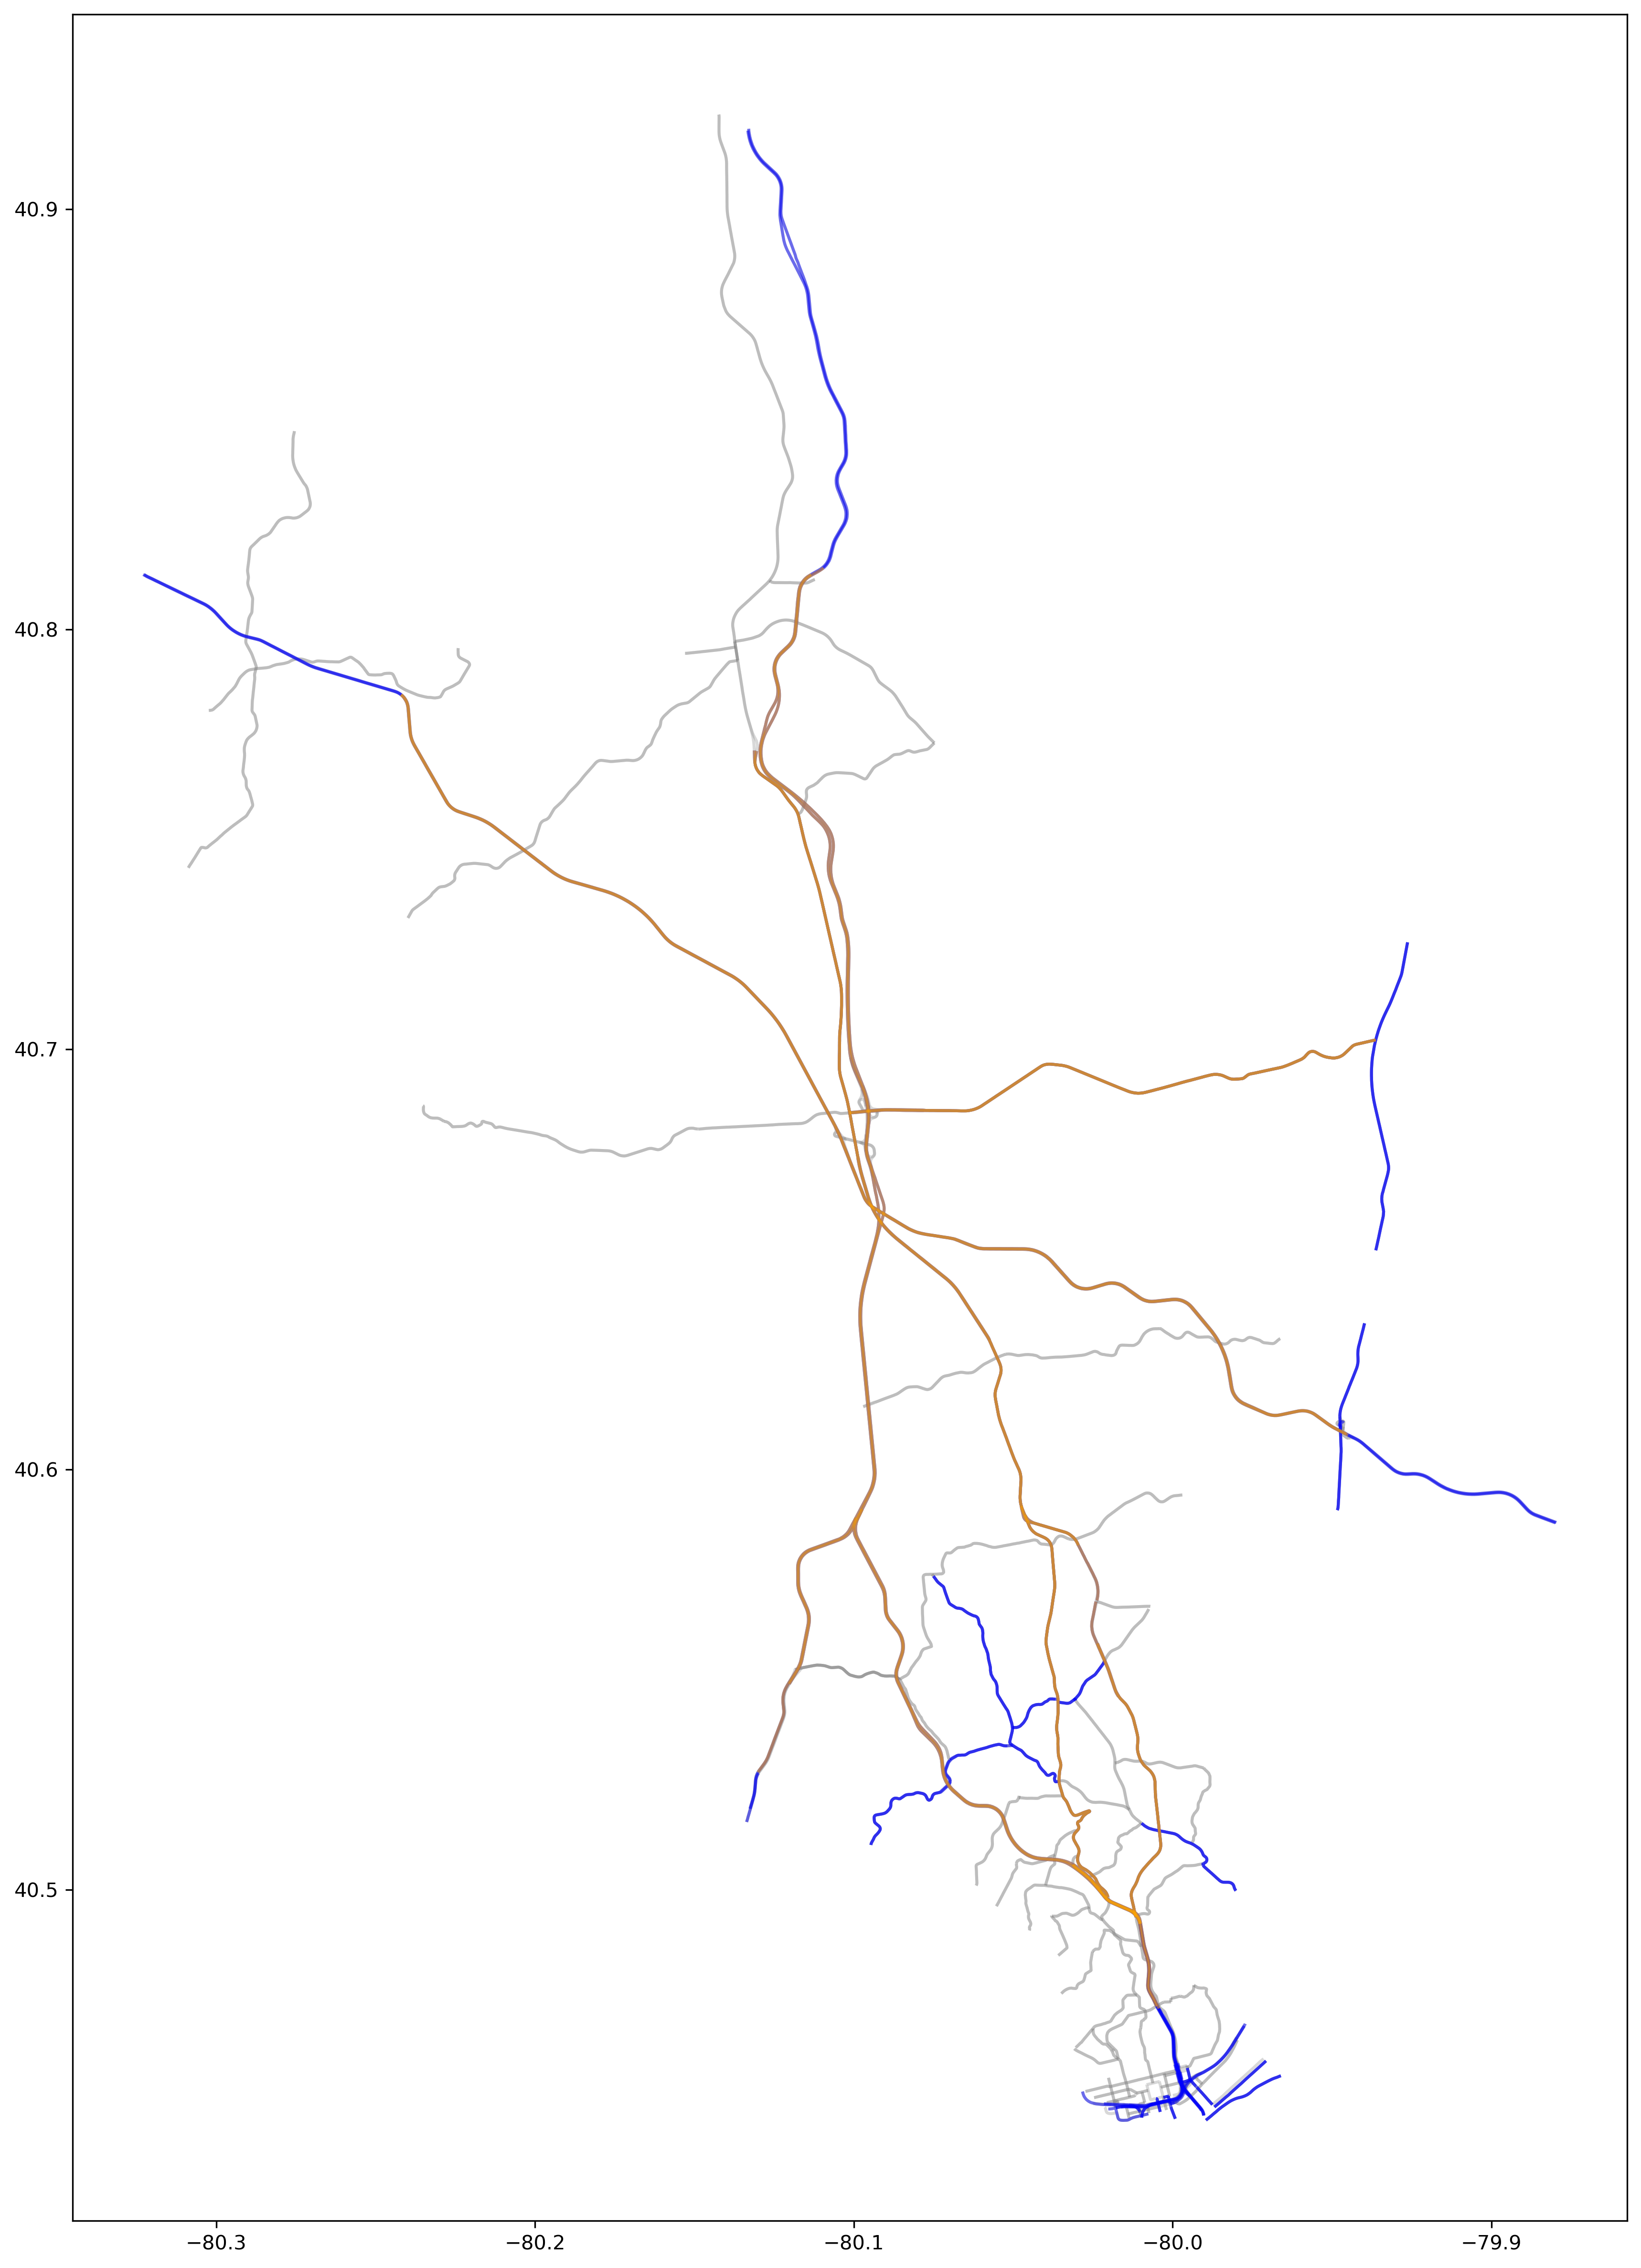

In [17]:
# Visualize 273 TMC segments covered by both shapefile and speeddata
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
gdf_tmc_cranberry.plot(ax=ax, color="grey", alpha=0.3)
gdf_tmc_cranberry[gdf_tmc_cranberry.tmc.isin(set(pd_spd_tmc_5min_all.tmc_code.unique()))].plot(ax=ax, color="blue", alpha=0.5)
gdf_tmc_cranberry[(gdf_tmc_cranberry.tmc.isin(set(pd_spd_tmc_5min_all.tmc_code.unique()))) & (gdf_tmc_cranberry.tmc.isin(set_tmc_segments_for_upstream))].plot(ax=ax, color="orange", alpha=0.5)

In [ ]:
# get indices of old_col that will remain as new columns
col_idx = []  # will store the indices of 194 old columns that will become new_X (173 inc, 21 weather & time)
col_name = []
for i in range(987):
    c = old_col[i]
    if "inc" in c and c[4:] in set_target_tmc:
        col_idx.append(i)
        col_name.append(c[4:])
col_idx += list(range(987, 1008)) # len 194, incident features: 1~173, weather & time: 174~194

In [2]:
df_tmc_cran = pd.read_csv("./data/cranberry_tmc_5min/cran_2019_tmc.csv")

In [5]:
df_tmc_cran.measurement_tstamp = pd.to_datetime(df_tmc_cran.measurement_tstamp)
df_tmc_cran = df_tmc_cran[
    (df_tmc_cran.measurement_tstamp.dt.date.isin(busi_date)) &
    (df_tmc_cran.measurement_tstamp.dt.hour*60 + df_tmc_cran.measurement_tstamp.dt.minute >= 330) &
    (df_tmc_cran.measurement_tstamp.dt.hour*60 + df_tmc_cran.measurement_tstamp.dt.minute < 1260) 
    ]

In [6]:
df_tmc_cran

,tmc_code,measurement_tstamp,speed,average_speed,reference_speed,travel_time_minutes,confidence_score,cvalue
1434570,104P51574,2019-02-11 05:30:00,38.0,29.0,42.0,0.50,30.0,100.0
1434571,104P51574,2019-02-11 05:31:00,38.0,29.0,42.0,0.50,30.0,100.0
1434572,104P51574,2019-02-11 05:32:00,38.0,29.0,42.0,0.50,30.0,100.0
1434573,104P51574,2019-02-11 05:33:00,38.0,29.0,42.0,0.50,30.0,100.0
1434574,104P51574,2019-02-11 05:34:00,38.0,29.0,42.0,0.50,30.0,100.0
...,...,...,...,...,...,...,...,...
232869517,104P11612,2019-07-23 20:55:00,47.0,39.0,44.0,0.19,30.0,95.0
232869518,104P11612,2019-07-23 20:56:00,47.0,39.0,44.0,0.19,30.0,95.0
232869519,104P11612,2019-07-23 20:57:00,47.0,39.0,44.0,0.19,30.0,95.0
232869520,104P11612,2019-07-23 20:58:00,48.0,39.0,44.0,0.18,30.0,87.0


In [7]:
df_tmc_cran.to_csv("./data/cranberry_tmc_5min/downsampled_tmc_all.csv", index=False)

In [2]:
df_xd_cran = pd.read_csv("./data/cranberry_xd_1min/cran_2019_xd.csv")

In [5]:
df_xd_cran.measurement_tstamp = pd.to_datetime(df_xd_cran.measurement_tstamp)
df_xd_cran = df_xd_cran[
    (df_xd_cran.measurement_tstamp.dt.date.isin(busi_date)) &
    (df_xd_cran.measurement_tstamp.dt.hour*60 + df_xd_cran.measurement_tstamp.dt.minute >= 330) &
    (df_xd_cran.measurement_tstamp.dt.hour*60 + df_xd_cran.measurement_tstamp.dt.minute < 1260) 
    ]

In [6]:
df_xd_cran

,xd_id,measurement_tstamp,speed,average_speed,reference_speed,travel_time_minutes,confidence_score,cvalue
1568489,135063797,2019-02-11 05:30:00,22.0,17.0,28.0,0.05,30.0,NaN
1568490,135063797,2019-02-11 05:31:00,22.0,17.0,28.0,0.05,30.0,NaN
1568491,135063797,2019-02-11 05:32:00,22.0,17.0,28.0,0.05,30.0,NaN
1568492,135063797,2019-02-11 05:33:00,22.0,17.0,28.0,0.05,30.0,NaN
1568493,135063797,2019-02-11 05:34:00,22.0,17.0,28.0,0.05,30.0,NaN
...,...,...,...,...,...,...,...,...
256017817,1310540446,2019-07-23 20:55:00,49.0,49.0,49.0,0.71,20.0,NaN
256017818,1310540446,2019-07-23 20:56:00,49.0,49.0,49.0,0.71,20.0,NaN
256017819,1310540446,2019-07-23 20:57:00,49.0,49.0,49.0,0.71,20.0,NaN
256017820,1310540446,2019-07-23 20:58:00,49.0,49.0,49.0,0.71,20.0,NaN


In [7]:
df_xd_cran.to_csv("./data/cranberry_xd_1min/downsampled_xd.csv", index=False)

In [5]:
df_xd_cran

,xd_id,measurement_tstamp,speed,average_speed,reference_speed,travel_time_minutes,confidence_score,cvalue
0,135063797,2019-02-10 00:00:00,28.0,28.0,28.0,0.04,10.0,NaN
1,135063797,2019-02-10 00:01:00,28.0,28.0,28.0,0.04,10.0,NaN
2,135063797,2019-02-10 00:02:00,28.0,28.0,28.0,0.04,10.0,NaN
3,135063797,2019-02-10 00:03:00,28.0,28.0,28.0,0.04,10.0,NaN
4,135063797,2019-02-10 00:04:00,28.0,28.0,28.0,0.04,10.0,NaN
...,...,...,...,...,...,...,...,...
256017996,1310540446,2019-07-23 23:55:00,49.0,49.0,49.0,0.71,10.0,NaN
256017997,1310540446,2019-07-23 23:56:00,49.0,49.0,49.0,0.71,10.0,NaN
256017998,1310540446,2019-07-23 23:57:00,49.0,49.0,49.0,0.71,10.0,NaN
256017999,1310540446,2019-07-23 23:58:00,49.0,49.0,49.0,0.71,10.0,NaN


In [4]:
df_tmc_cran

,tmc_code,measurement_tstamp,speed,average_speed,reference_speed,travel_time_minutes,confidence_score,cvalue
0,104P51574,2019-02-10 00:00:00,45.0,42.0,42.0,0.42,30.0,100.0
1,104P51574,2019-02-10 00:01:00,45.0,42.0,42.0,0.42,30.0,100.0
2,104P51574,2019-02-10 00:02:00,45.0,42.0,42.0,0.42,30.0,100.0
3,104P51574,2019-02-10 00:03:00,45.0,42.0,42.0,0.42,30.0,100.0
4,104P51574,2019-02-10 00:04:00,45.0,42.0,42.0,0.42,30.0,100.0
...,...,...,...,...,...,...,...,...
232869697,104P11612,2019-07-23 23:55:00,43.0,44.0,44.0,0.20,30.0,100.0
232869698,104P11612,2019-07-23 23:56:00,43.0,44.0,44.0,0.20,30.0,100.0
232869699,104P11612,2019-07-23 23:57:00,44.0,44.0,44.0,0.20,10.0,NaN
232869700,104P11612,2019-07-23 23:58:00,48.0,44.0,44.0,0.18,30.0,71.0


In [7]:
df_tmc_cran.measurement_tstamp = pd.to_datetime(df_tmc_cran.measurement_tstamp)
temp = df_tmc_cran.pivot(index = "measurement_tstamp", columns = "tmc_code", values = "speed") 

In [ ]:
temp

In [14]:
# spd_tmc contains the speed data of tmc segments, and only covers 195 tmc segments in our craberry shapefile
gdf_xd_cranberry = gpd.read_file("./data/shape/xd_shape_cranberry/xd_cranberry_for_sjoin_v2.geojson")  # features of 1401 unique xd segments manually selected from PA shape file through QGIS; shape (1401, 25)
gdf_tmc_cranberry = gpd.read_file("./data/shape/tmc_shape_cranberry/tmc_cranberry_v2.geojson")  # id and geometry of 1037 unique tmc segments in cranberry shape file, 383 of which are covered in "set_spd_tmc_segments"; shape (1037, 16) 

In [21]:
with open("./id_cranberry_XD.txt", "w") as f:
    for i, id in enumerate(list(gdf_xd_cranberry.XDSegID)):
        f.write(id)
        if i != len(list(gdf_xd_cranberry.XDSegID))-1:
            f.write(",")


In [ ]:
with open("./id_cranberry_TMC.txt", "w") as f:
    for i, id in enumerate(list(gdf_tmc_cranberry.tmc)):
        f.write(id)
        if i != len(list(gdf_tmc_cranberry.tmc))-1:
            f.write(",")

In [2]:
# dict_upstream_unique_xd_str = pickle.load(open("./data/dict_upstream_unique_xd_str.pkl", "rb"))
# dict_upstream_unique_tmc = pickle.load(open("./data/dict_upstream_unique_tmc.pkl", "rb"))
# dict_upstream_unique_xd_str_5_miles = pickle.load(open("./data/dict_upstream_unique_xd_str_5_miles.pkl", "rb"))
# dict_upstream_unique_tmc_5_miles = pickle.load(open("./data/dict_upstream_unique_tmc_5_miles.pkl", "rb"))

# dict_upstream_xd_str = pickle.load(open("./data/dict_upstream_xd_str.pkl", "rb"))
# dict_upstream_tmc = pickle.load(open("./data/dict_upstream_tmc.pkl", "rb"))
# dict_upstream_xd_str_5_miles = pickle.load(open("./data/dict_upstream_xd_str_5_miles.pkl", "rb"))
# dict_upstream_tmc_5_miles = pickle.load(open("./data/dict_upstream_tmc_5_miles.pkl", "rb"))

# set_tmc_segments_for_upstream = pickle.load(open("./pipeline_v2/data_processing/set_tmc_segments_for_upstream.pkl", "rb"))
# set_xd_segments_str_for_upstream = pickle.load(open("./pipeline_v2/data_processing/set_xd_segments_str_for_upstream.pkl", "rb"))

# dict_miles_tmc_for_upstream = pickle.load(open("./pipeline_v2/data_processing/dict_miles_tmc_for_upstream.pkl", "rb"))
# dict_miles_xd_for_upstream = pickle.load(open("./pipeline_v2/data_processing/dict_miles_xd_str_for_upstream.pkl", "rb"))

# dict_prev_tmc = pickle.load(open("./data/dict_prev_tmc.pkl", "rb"))
# dict_prev_xd = pickle.load(open("./data/dict_prev_xd.pkl", "rb"))

gdf_shp_tmc = gpd.read_file('./data/shapefiles/tmc_shape_cranberry/cranberry.shp').drop_duplicates()
gdf_shp_xd = gpd.read_file("./data/shapefiles/xd_shape_cranberry/xd_cranberry_for_sjoin.geojson") # 556 xd segments from shapefile
gdf_shp_xd = gdf_shp_xd.rename(columns={"XDSegID":"id_xd_str", "PreviousXD":"id_xd_prev", "NextXDSegI":"id_xd_next", "Miles":"miles_xd"})

In [3]:
gdf_shp_tmc_cran_new = gpd.read_file("./data/shapefiles/network_tmc.geojson")

<AxesSubplot: >

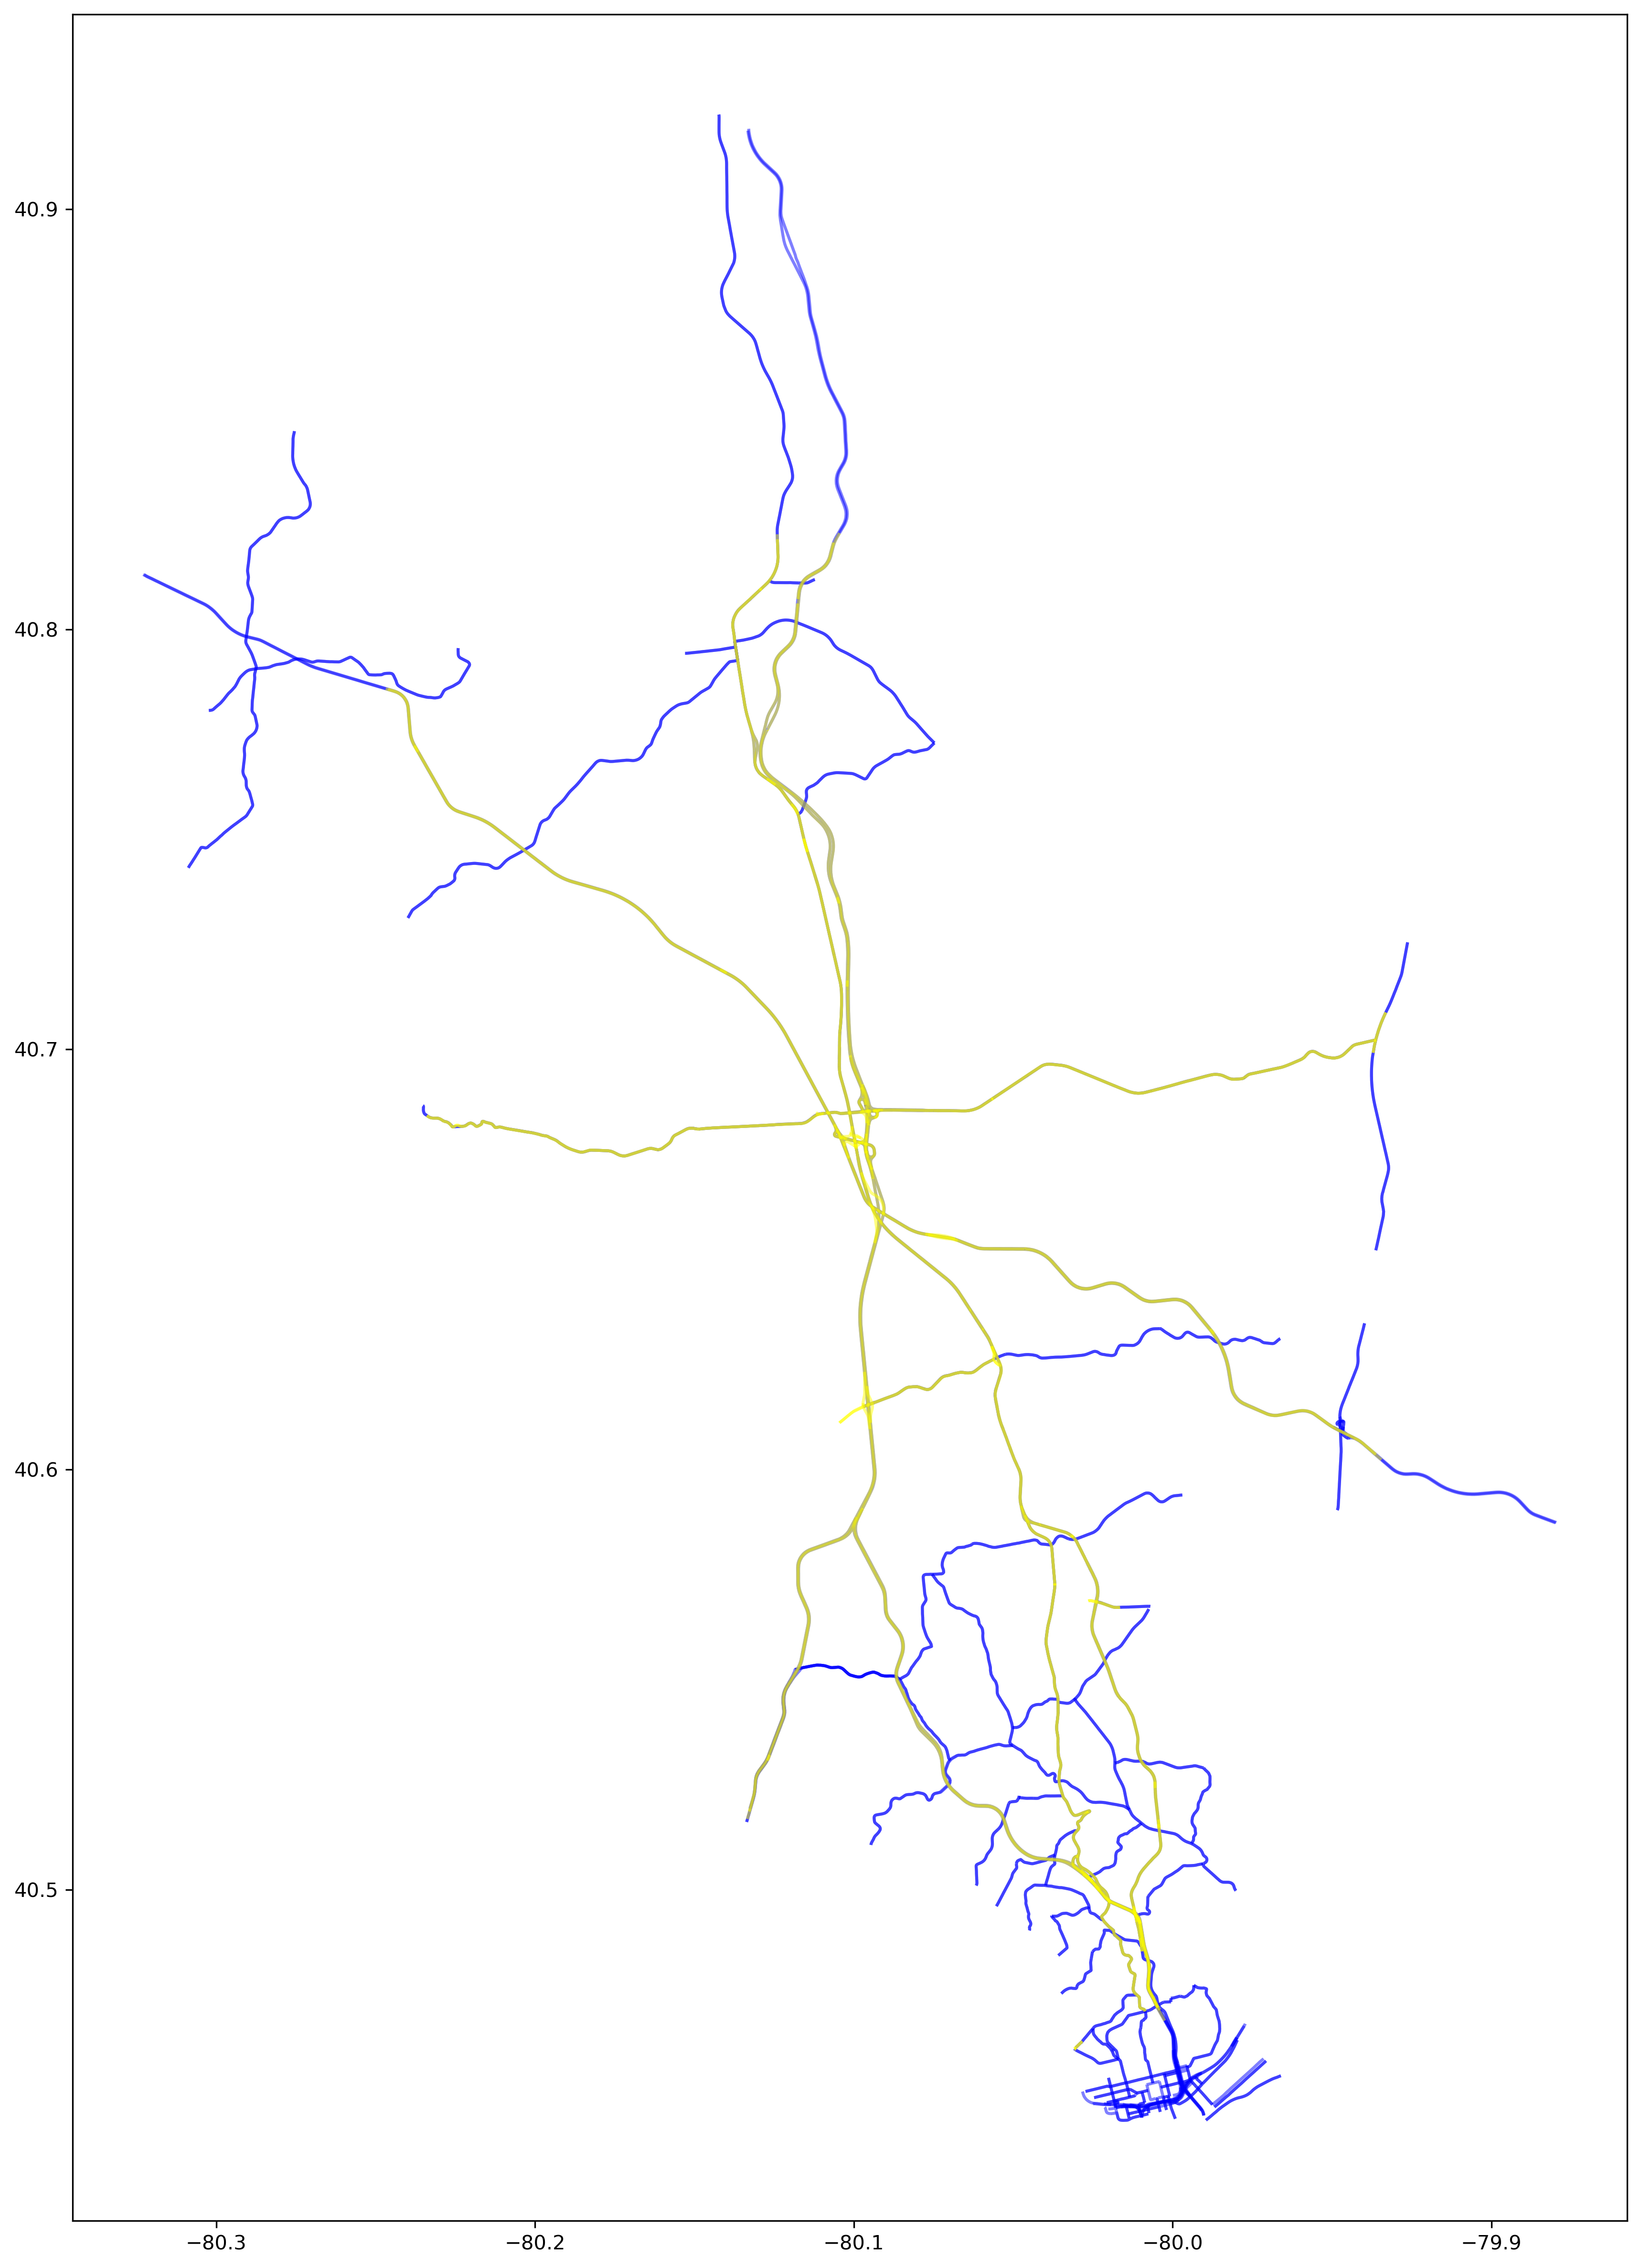

In [9]:
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
# gdf_shp_tmc.plot(ax=ax, color="yellow", alpha=0.7) # new entire TMC segments in cranberry 
gdf_shp_tmc_cran_new.plot(ax=ax, color="blue", alpha=0.5) # new entire TMC segments in cranberry 
gdf_shp_xd.plot(ax=ax, color="yellow", alpha=0.5) # new entire TMC segments in cranberry 

In [9]:
limit = 5

<AxesSubplot: >

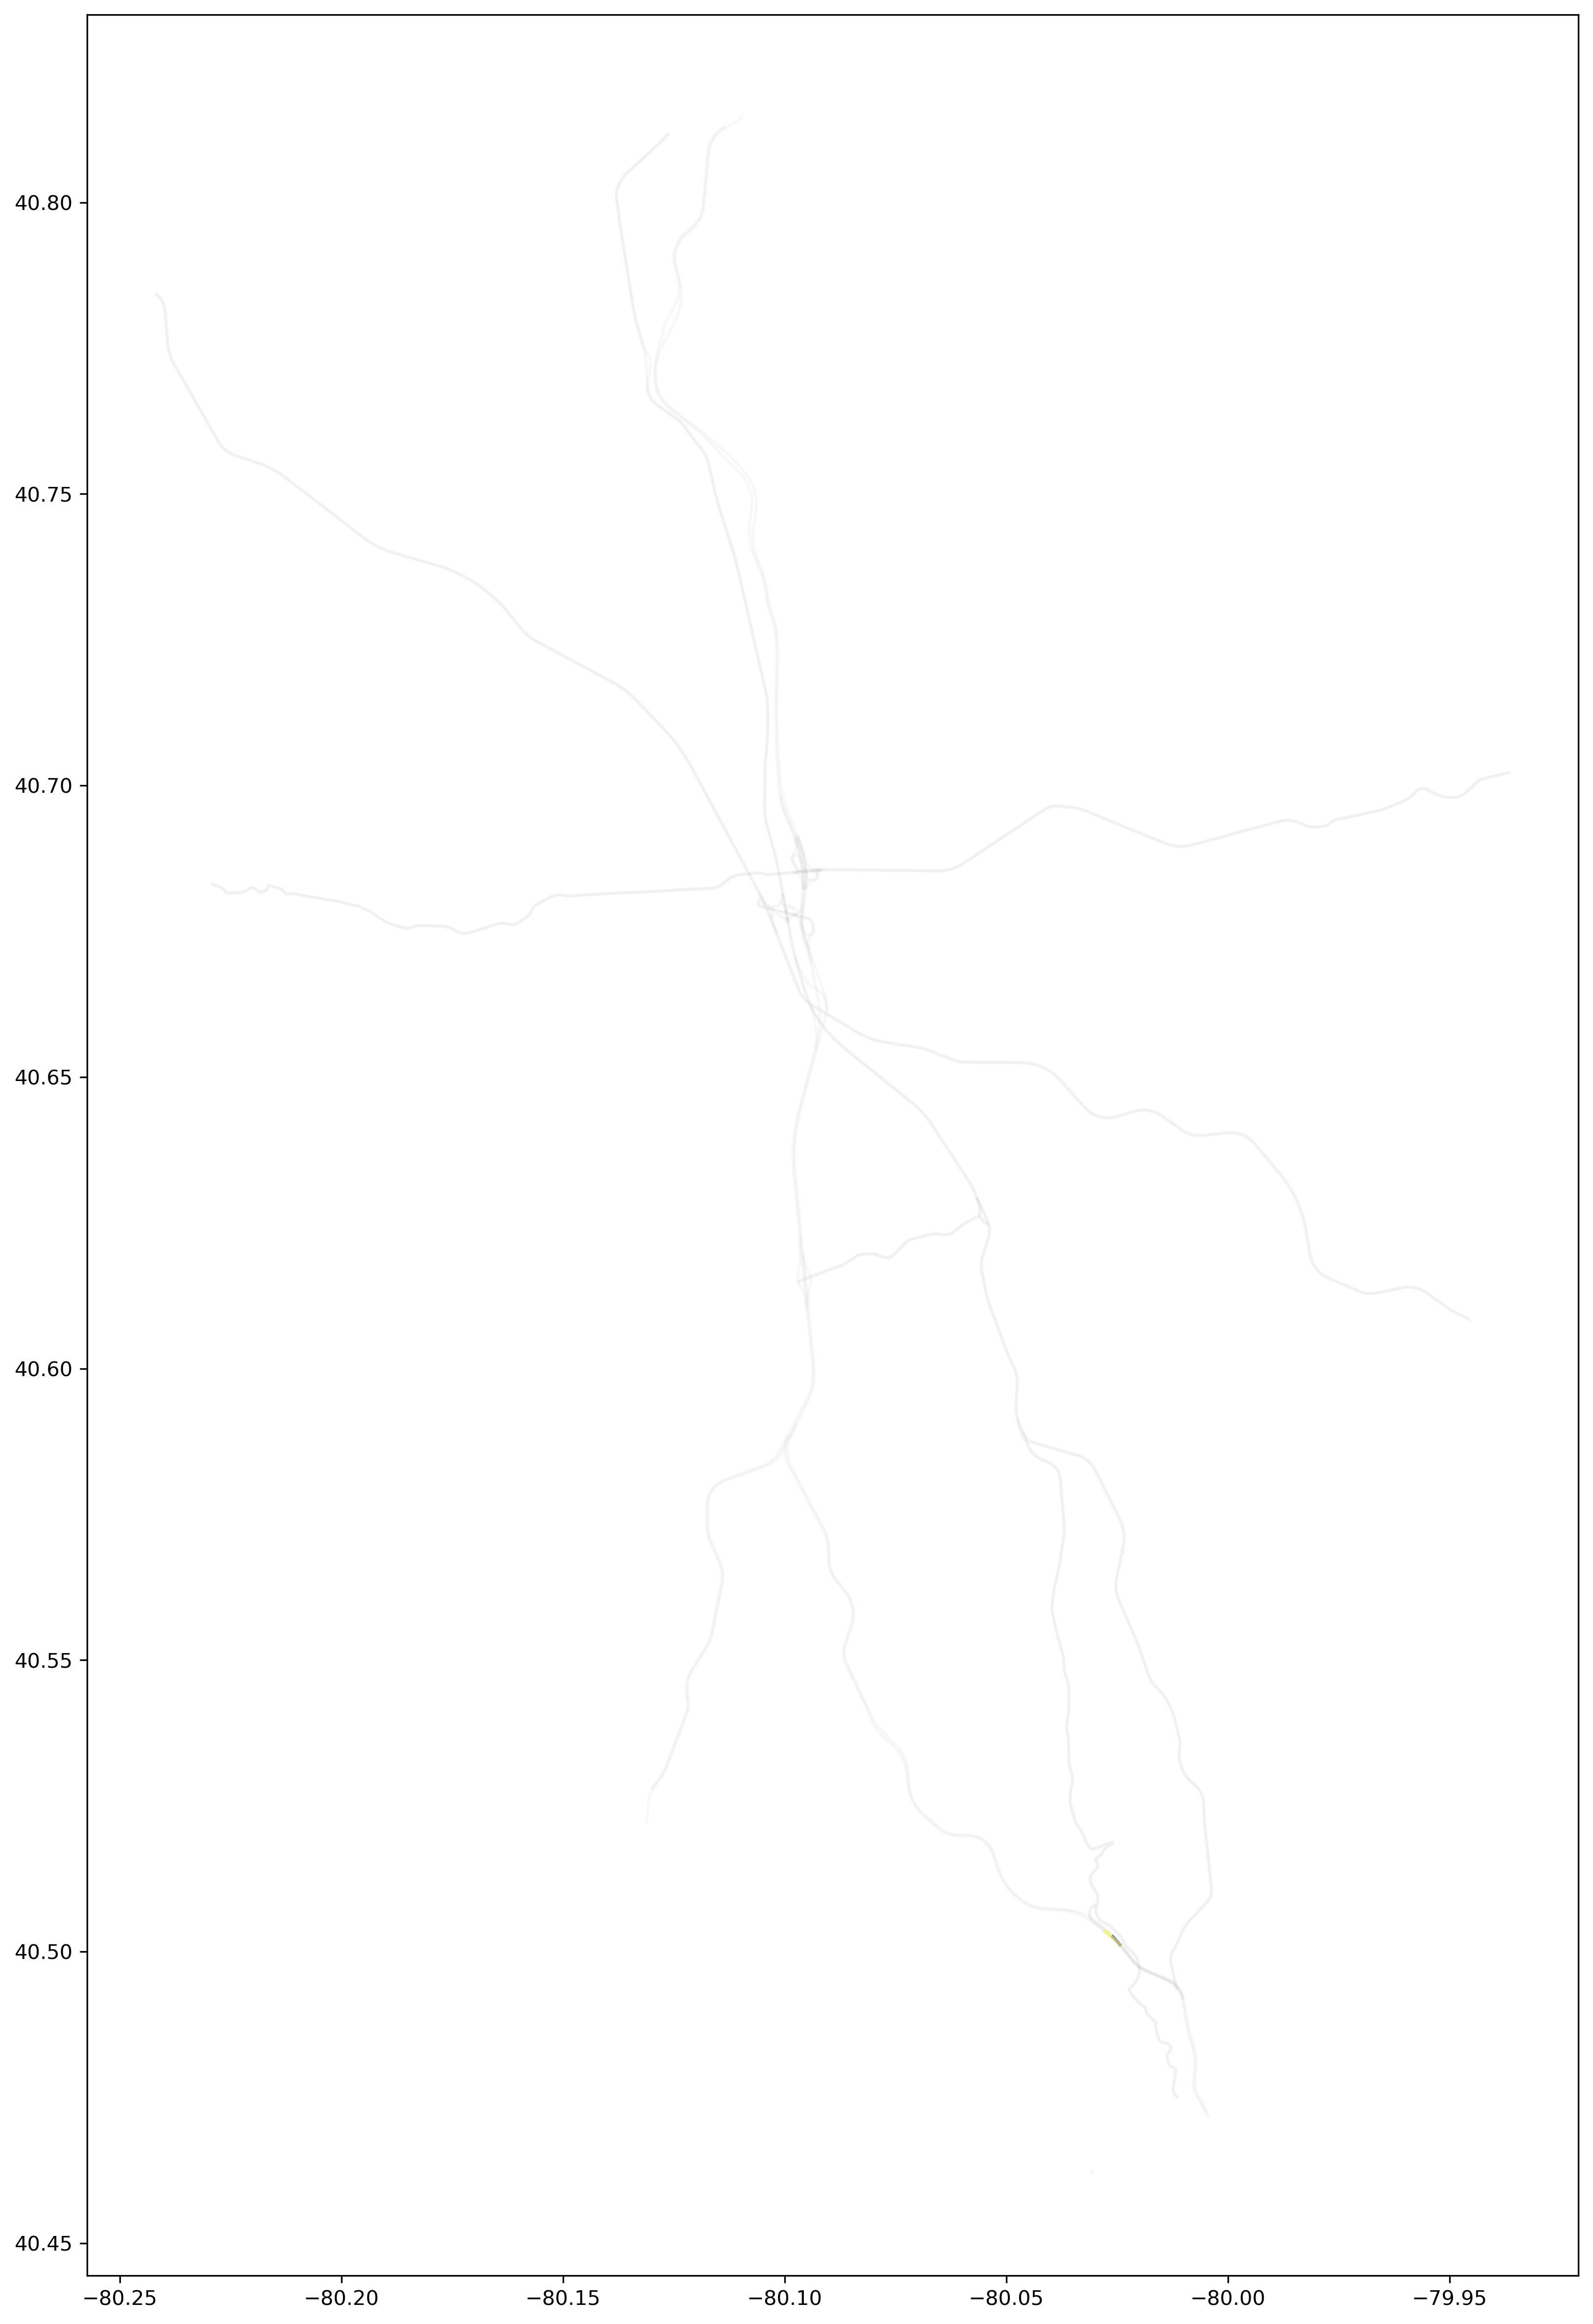

In [75]:
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
gdf_shp_tmc.plot(ax=ax, color="grey", alpha=0.05) # entire TMC segments in cranberry 
# gdf_shp_tmc[gdf_shp_tmc.id == "104P06223"].plot(ax=ax, color="blue", alpha=0.5) # TMC segment
# gdf_shp_tmc[gdf_shp_tmc.id == "104+06678"].plot(ax=ax, color="yellow", alpha=0.5) # TMC segment
gdf_shp_xd[gdf_shp_xd.id_xd_str == "1310331567"].plot(ax=ax, color="blue", alpha=0.5) # XD segment
gdf_shp_xd[gdf_shp_xd.id_xd_str == "1310303829"].plot(ax=ax, color="yellow", alpha=0.5) # XD segment
# gdf_shp_xd[gdf_shp_xd.id_xd_str == "1310569369"].plot(ax=ax, color="yellow", alpha=0.5) # XD segment

current tmc:  104+11466
upstream within range:  [['104P04443', '104+04741', '104P04740', '104+04740', '104P04739', '104+04739', '104+04738', '104+04737', '104P04736', '104+04736', '104P04735'], ['104P04443', '104+04443', '104P04442', '104+04442', '104P04441', '104+04441', '104P04440'], ['104P04443', '104+04443', '104P04442', '104+04442', '104P04441', '104+04441', '104P04533']]
MORE THAN ONE UPSTREAM PATH!!! There are 3 upstream paths


<AxesSubplot: >

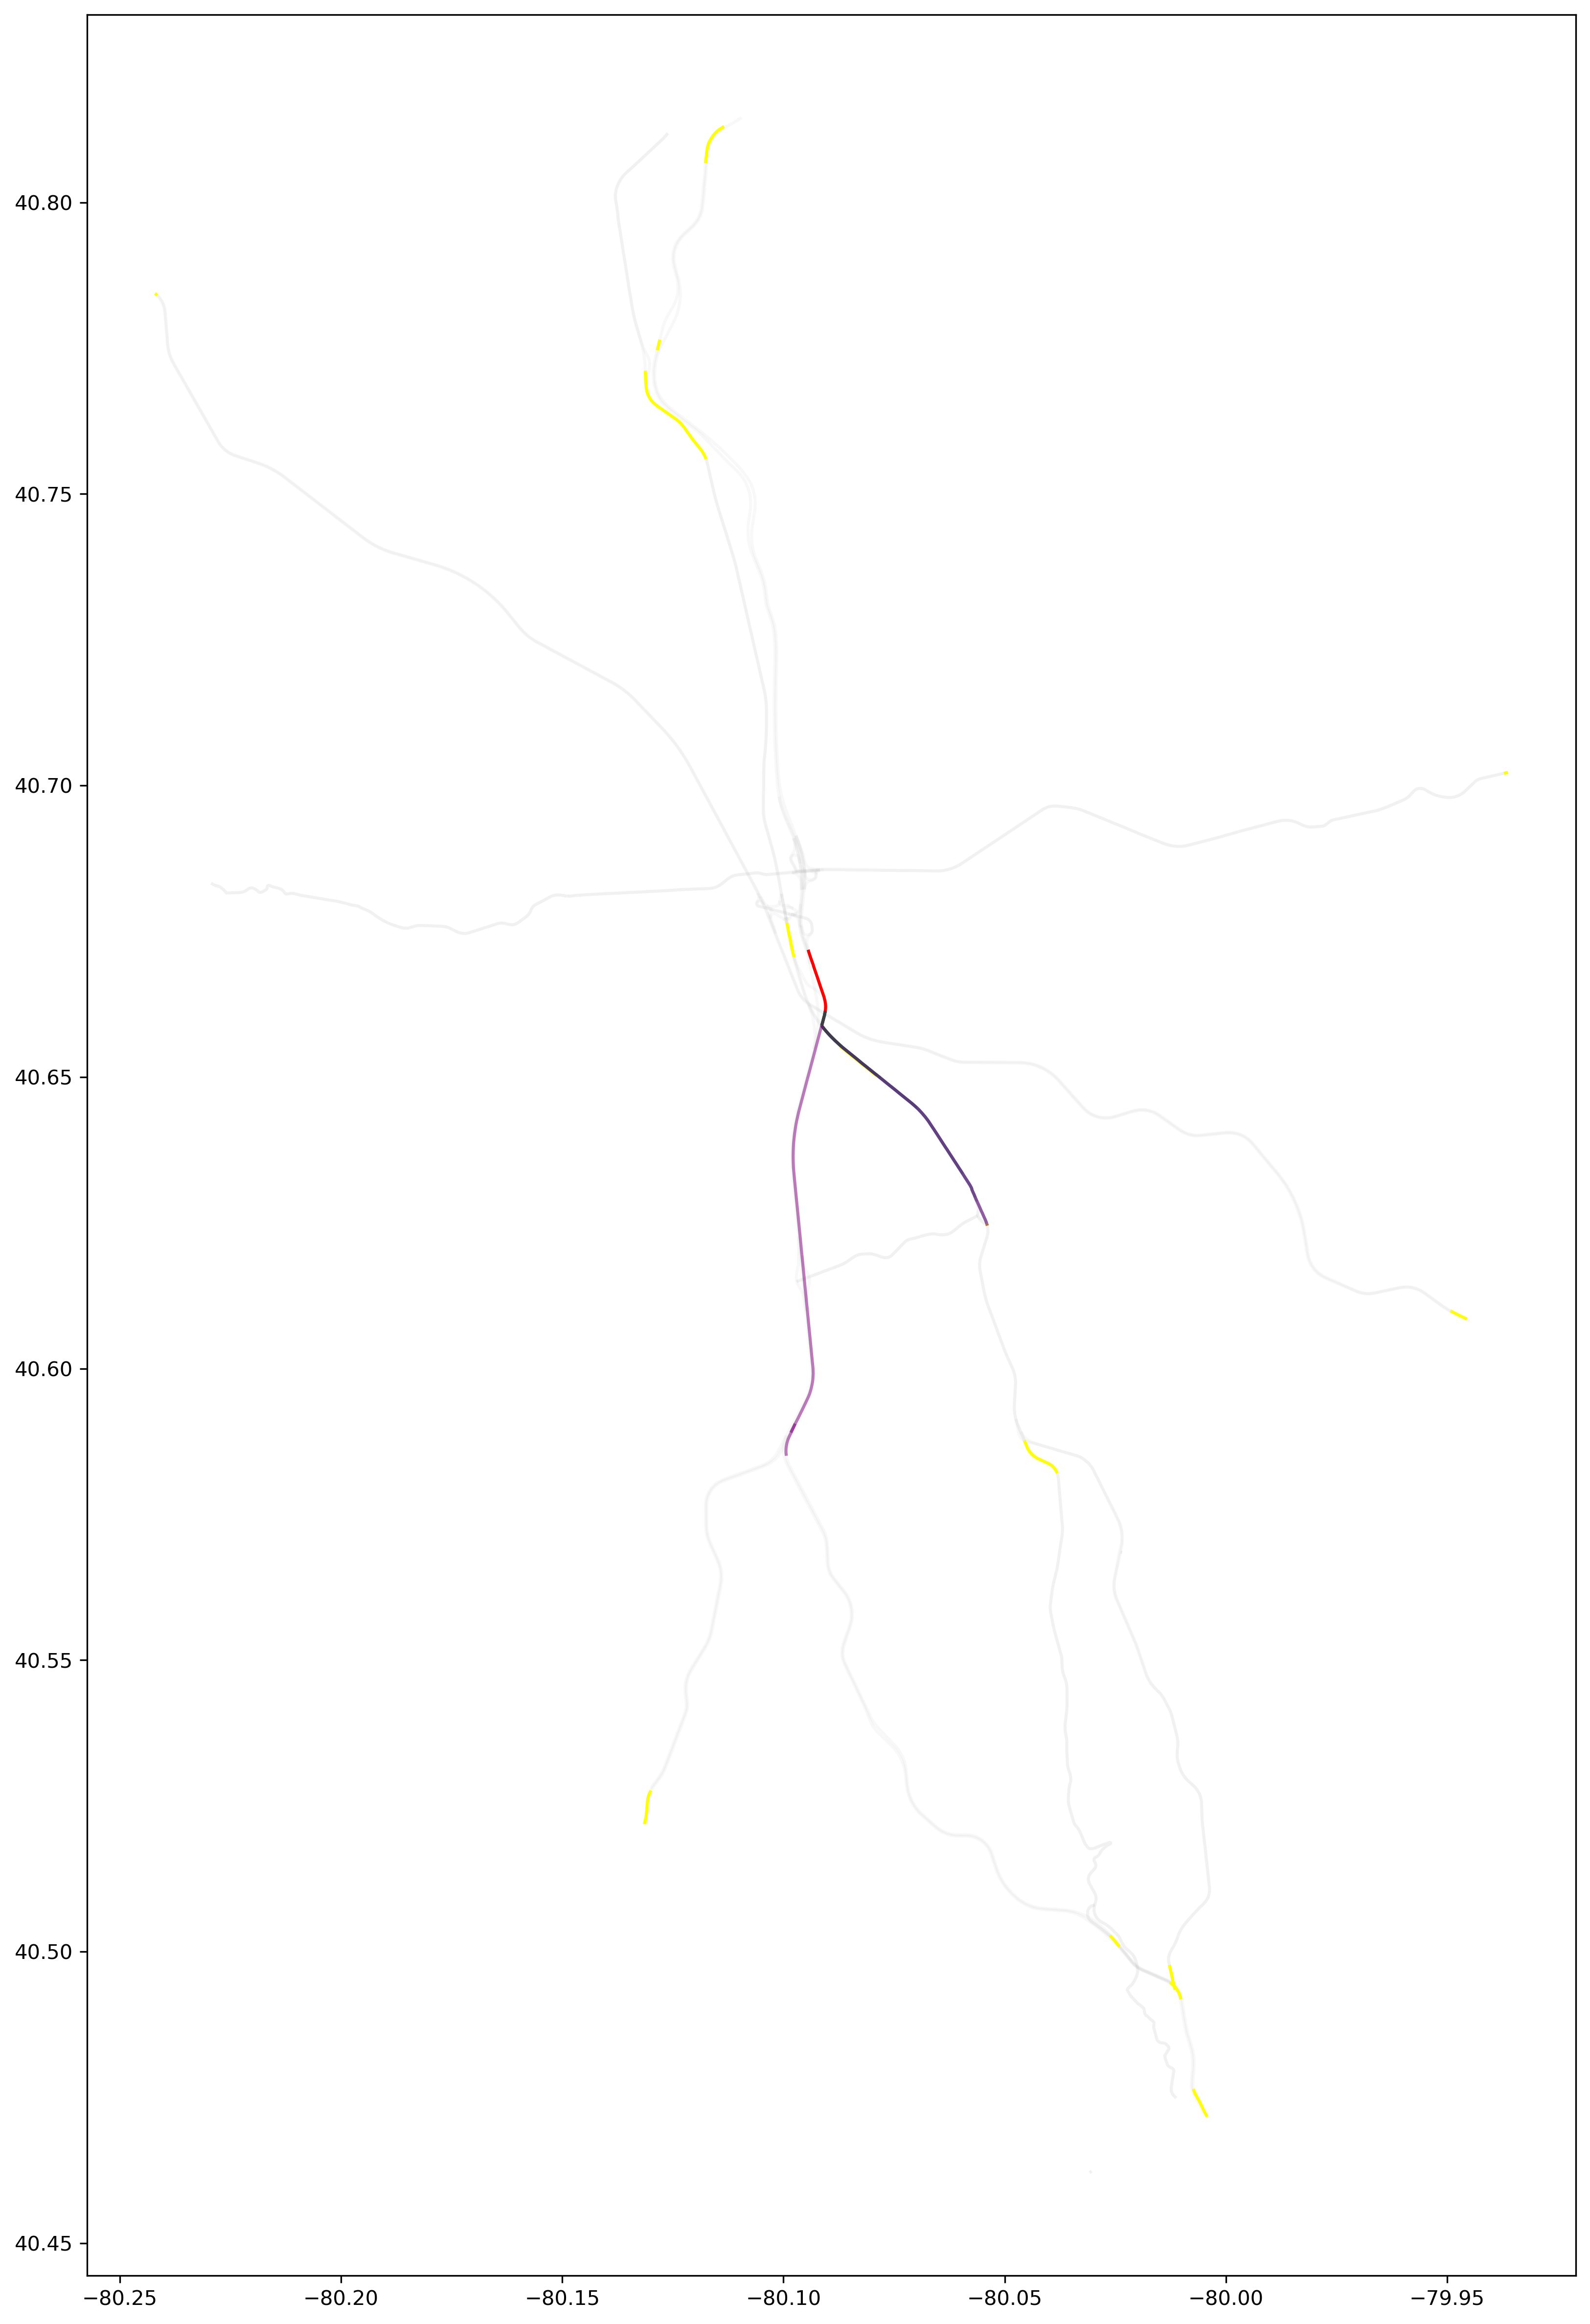

In [13]:
i = 3
check_curr_tmc = "104+11466" #list(set_tmc_segments_for_upstream)[i]

print("current tmc: ", check_curr_tmc)#, df_tmc_attr[df_tmc_attr.id_tmc == check_curr_tmc].direction)

check_upstream = dict_upstream_tmc[check_curr_tmc]
check_upstream_within_range = dict_upstream_tmc_5_miles[check_curr_tmc]

print("upstream within range: ", check_upstream_within_range)
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
gdf_shp_tmc.plot(ax=ax, color="grey", alpha=0.05) # entire TMC segments in cranberry 
gdf_shp_tmc[(gdf_shp_tmc.id.isin(set_tmc_segments_for_upstream)) & (~gdf_shp_tmc.id.isin(dict_prev_tmc))].plot(ax=ax, color="yellow") # TMC segments without prev neighbors
gdf_shp_tmc[gdf_shp_tmc.id == check_curr_tmc].plot(ax=ax, color="red") # source
if len(check_upstream_within_range) > 1:
    print(f"MORE THAN ONE UPSTREAM PATH!!! There are {len(check_upstream_within_range)} upstream paths")
j = 0

# upstream segments within range
for k, u in enumerate(check_upstream_within_range[j]):
    gdf_shp_tmc[gdf_shp_tmc.id == u].plot(ax=ax, color="blue", alpha= (len(check_upstream_within_range[j])-k)/len(check_upstream_within_range[j]))  

# upstream segments 
for k, u in enumerate(check_upstream[j]):
    gdf_shp_tmc[gdf_shp_tmc.id == u].plot(ax=ax, color="green", alpha= (len(check_upstream[j])-k)/len(check_upstream[j]))  

# upstream unique segments
# gdf_shp_tmc[gdf_shp_tmc.id.isin(dict_upstream_unique_tmc[check_curr_tmc])].plot(ax=ax, color="purple", alpha=0.5) 
gdf_shp_tmc[gdf_shp_tmc.id.isin(dict_upstream_unique_tmc_5_miles[check_curr_tmc])].plot(ax=ax, color="purple", alpha=0.5)

current xd:  1310597390
MORE THAN ONE UPSTREAM PATH!!! There are 17 upstream paths


<AxesSubplot: >

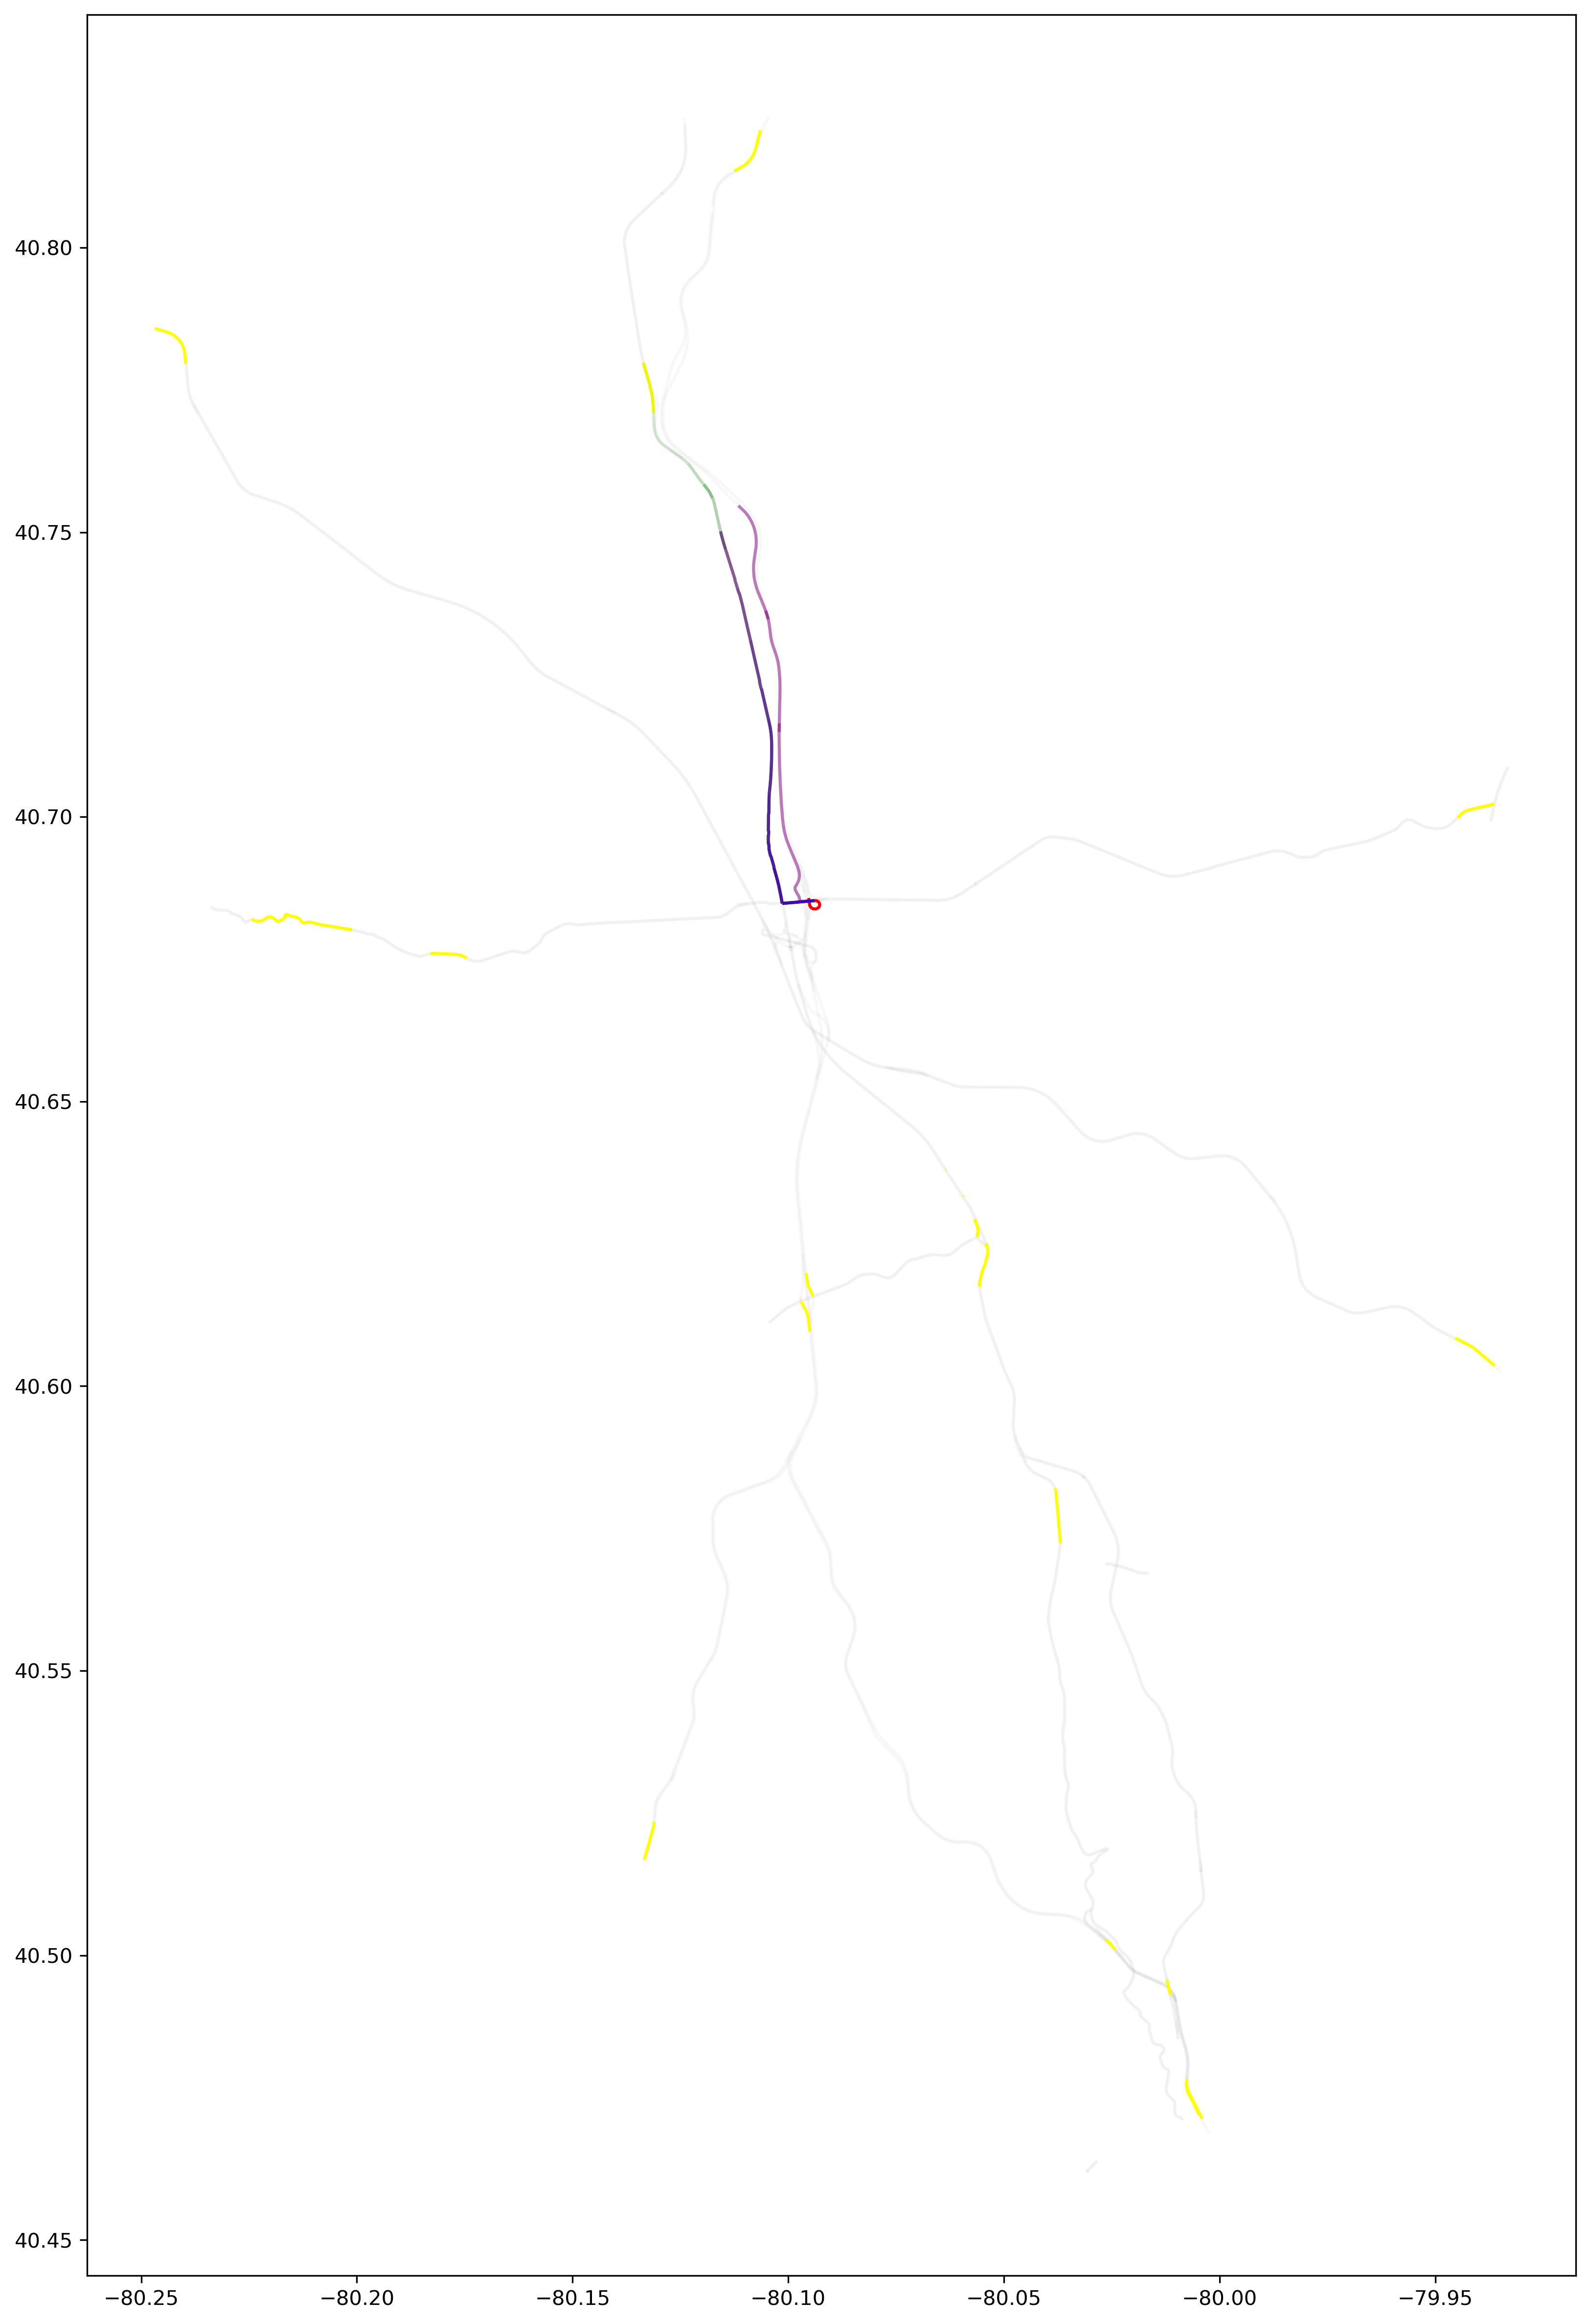

In [18]:
# Visualize and manually check upstream segments starting from each of 4 segments
i = 10
check_curr_xd = list(set_xd_segments_str_for_upstream)[i]
print("current xd: ", check_curr_xd)#, df_xd_attr[df_xd_attr.id_xd_str == check_curr_xd].Bearing)
check_upstream_xd = dict_upstream_xd_str[check_curr_xd]
check_upstream_xd_within_range = dict_upstream_xd_str_5_miles[check_curr_xd]

# print("upstream: ", check_upstream_xd)
fig, ax = plt.subplots(1,figsize=(30,20), dpi=300)
gdf_shp_xd.plot(ax=ax, color="grey", alpha=0.05) # entire XD segments in cranberry 
gdf_shp_xd[(gdf_shp_xd.id_xd_str.isin(set_xd_segments_str_for_upstream)) & (~gdf_shp_xd.id_xd_str.isin(dict_prev_xd))].plot(ax=ax, color="yellow") # TMC segments without prev neighbors
gdf_shp_xd[gdf_shp_xd.id_xd_str == check_curr_xd].plot(ax=ax, color="red") # source
if len(check_upstream_xd) > 1:
    print(f"MORE THAN ONE UPSTREAM PATH!!! There are {len(check_upstream_xd)} upstream paths")
j = 0
# upstream segments
for k, u in enumerate(check_upstream_xd[j]):
    gdf_shp_xd[gdf_shp_xd.id_xd_str == u].plot(ax=ax, color="green", alpha= (len(check_upstream_xd[j])-k)/len(check_upstream_xd[j]))  

# upstream segments within range
for k, u in enumerate(check_upstream_xd_within_range[j]):
    gdf_shp_xd[gdf_shp_xd.id_xd_str == u].plot(ax=ax, color="blue", alpha= (len(check_upstream_xd_within_range[j])-k)/len(check_upstream_xd_within_range[j]))  

# all upstream segments within range
gdf_shp_xd[gdf_shp_xd.id_xd_str.isin(dict_upstream_unique_xd_str_5_miles[check_curr_xd])].plot(ax=ax, color="purple", alpha=0.5) # 

In [4]:
df_tmc_attr = pd.read_csv("../../data/cranberry_tmc_5min/manually_select_cranberry_2019_dont_average_2/TMC_Identification.csv")
df_tmc_attr = df_tmc_attr.rename(columns={"tmc": "id_tmc", "miles":"miles_tmc"})


,id_tmc,id_xd,prev_xd,next_xd,xd_start_lat,xd_start_long,xd_end_lat,xd_end_long,tmc_start_lat,tmc_start_long,tmc_end_lat,tmc_end_long,angle
264,104-04439,1310569369,1.310271e+09,1.310271e+09,40.55586,-80.11625,40.54852,-80.12094,40.58853,-80.0993,40.55586,-80.11625,0.028643
265,104-04439,1310270700,1.310271e+09,1.310569e+09,40.56387,-80.11424,40.55586,-80.11625,40.58853,-80.0993,40.55586,-80.11625,0.074082
266,104-04439,1310270712,1.310271e+09,1.310271e+09,40.57162,-80.11739,40.56387,-80.11424,40.58853,-80.0993,40.55586,-80.11625,0.275226
267,104-04439,1310270769,1.310271e+09,1.310271e+09,40.57955,-80.11622,40.57162,-80.11739,40.58853,-80.0993,40.55586,-80.11625,0.105714
268,104-04439,1310270777,1.310271e+09,1.310271e+09,40.58291,-80.10652,40.57955,-80.11622,40.58853,-80.0993,40.55586,-80.11625,0.241516
269,104-04439,1310356618,NaN,1.310357e+09,40.58864,-80.09920,40.58094,-80.09740,40.58853,-80.0993,40.55586,-80.11625,0.225439
270,104-04439,1310270745,1.310545e+09,1.310271e+09,40.58864,-80.09920,40.58291,-80.10652,40.58853,-80.0993,40.55586,-80.11625,0.136251


In [21]:
df = pd.DataFrame([[np.nan, 2, np.nan, 0],
...                    [3, 4, np.nan, 1],
...                    [np.nan, np.nan, np.nan, np.nan],
...                    [np.nan, 3, np.nan, 4]],
...                   columns=list("ABCD"))

In [20]:
df2 = pd.DataFrame([[2, np.nan, 0],
...                    [4, np.nan, 1],
...                    [np.nan, np.nan, np.nan],
...                    [3, np.nan, 4]],
...                   columns=list("ACD"))

In [47]:
df = pd.DataFrame(np.arange(15).reshape((3,5)), columns=["a", "b", "c", "d", "e"])

In [48]:
df

,a,b,c,d,e
0,0,1,2,3,4
1,5,6,7,8,9
2,10,11,12,13,14


In [23]:
df_2 = df*3

In [24]:
df_2

,a,b,c,d,e
0,0,3,6,9,12
1,15,18,21,24,27
2,30,33,36,39,42


In [27]:
df_2[["a", "c"]]

,a,c
0,0,6
1,15,21
2,30,36


In [29]:
(df_2[df_2.index>0][["a", "c"]]>0).astype(float)

,a,c
1,1.0,1.0
2,1.0,1.0


In [30]:
temp = (df_2[df_2.index>0][["a", "c"]]>0).astype(float)

In [31]:
temp

,a,c
1,1.0,1.0
2,1.0,1.0


In [51]:
df[df.index>0][["a", "c"]]

,a,c
1,5,7
2,10,12


In [52]:
df[df.index>0][["a", "c"]].where(df[df.index>0][["a", "c"]] < temp+10, 1)

,a,c
1,5,7
2,10,1


In [53]:
df.loc[df.index>0, ["a", "c"]] = df[df.index>0][["a", "c"]].where(df[df.index>0][["a", "c"]] < temp+10, 1)

In [54]:
df

,a,b,c,d,e
0,0,1,2,3,4
1,5,6,7,8,9
2,10,11,1,13,14


In [58]:
condition = (df.index//2==0) & (df.index < 1)

In [59]:
df.loc[condition, ["a", "d"]]

,a,d
0,0,3


In [36]:
df[df.index>0][["a", "c"]]

,a,c
1,5,7
2,10,12


In [40]:
df

,a,b,c,d,e
0,0,1,2,3,4
1,5,6,7,8,9
2,10,11,12,13,14


In [22]:
df

,A,B,C,D
0,NaN,2.0,NaN,0.0
1,3.0,4.0,NaN,1.0
2,NaN,NaN,NaN,NaN
3,NaN,3.0,NaN,4.0


In [23]:
df2

,A,C,D
0,2.0,NaN,0.0
1,4.0,NaN,1.0
2,NaN,NaN,NaN
3,3.0,NaN,4.0


In [25]:
df[["A"]] - df2[["A"]]

,A
0,NaN
1,-1.0
2,NaN
3,NaN


In [8]:
df[["A", "B"]].mean(axis=1)

0    2.0
1    3.5
2    NaN
3    3.0
dtype: float64

In [5]:
df["A"]

0    NaN
1    3.0
2    NaN
3    NaN
Name: A, dtype: float64

In [6]:
temp = pd.Series([1,2,3,4])

In [9]:
df["A"].fillna(df[["A", "B"]].mean(axis=1))

0    2.0
1    3.0
2    NaN
3    3.0
Name: A, dtype: float64

In [14]:
df["A"].fillna(df["C"])

0    NaN
1    3.0
2    NaN
3    NaN
Name: A, dtype: float64

In [39]:
y = np.load("./data/new_Y_v2.npy")

In [40]:
y.shape

(21060, 75, 2)

In [4]:
a = np.arange(24).reshape(6,4)
b = [0, 2]

In [7]:
c = a.reshape(3,2,4)

In [8]:
c

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7]],

       [[ 8,  9, 10, 11],
        [12, 13, 14, 15]],

       [[16, 17, 18, 19],
        [20, 21, 22, 23]]])

In [9]:
c[b, :, :]

array([[[ 0,  1,  2,  3],
        [ 4,  5,  6,  7]],

       [[16, 17, 18, 19],
        [20, 21, 22, 23]]])

In [9]:
tmc_xd_join = pd.read_csv("./data/tmc_xd_join.csv").dropna(subset={"XDSegID"})  # contains all new_out_tmc and new_in_tmc
tmc_xd_join.XDSegID = tmc_xd_join.XDSegID.apply(int).apply(str)
tmc_xd_join = tmc_xd_join.rename(columns={"id":"id_tmc", "XDSegID":"id_xd"})

In [16]:
tmc_xd_join

,id_tmc,OID,id_xd,PreviousXD,NextXDSegI,FRC,RoadNumber,RoadName,LinearID,Country,...,SlipRoad,SpecialRoa,RoadList,StartLat,StartLong,EndLat,EndLong,Bearing,XDGroup,ShapeSRID
0,104P06676,NaN,388051958,NaN,NaN,0.0,228.0,PA 228,NaN,United States,...,0.0,NaN,PA 228,40.68528,-80.09392,40.68540,-80.09267,E,1970621.0,4326.0
1,104P06676,NaN,429090769,1.310324e+09,1.310291e+09,0.0,228.0,PA 228,NaN,United States,...,0.0,NaN,PA 228,40.68540,-80.09267,40.68543,-80.09180,E,514061.0,4326.0
2,104P06676,NaN,1310323857,1.310598e+09,4.290908e+08,0.0,228.0,PA 228,NaN,United States,...,0.0,NaN,PA 228,40.68528,-80.09392,40.68540,-80.09267,E,514061.0,4326.0
3,104P06676,NaN,1310330692,NaN,1.310331e+09,0.0,NaN,NaN,NaN,United States,...,1.0,NaN,NaN,40.68480,-80.09259,40.68540,-80.09267,N,3461167.0,4326.0
4,104P06676,NaN,1310334146,1.310597e+09,1.310323e+09,0.0,NaN,NaN,NaN,United States,...,1.0,NaN,NaN,40.68677,-80.09629,40.68241,-80.09592,S,3463008.0,4326.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1439,104+09201,NaN,1310398365,1.310321e+09,1.310254e+09,1.0,19.0,US 19,NaN,United States,...,0.0,NaN,US 19,40.56355,-80.03885,40.55419,-80.03847,S,531444.0,4326.0
1440,104+09201,NaN,1310514659,1.310346e+09,4.290913e+08,2.0,NaN,Ingomar Road,NaN,United States,...,0.0,NaN,Ingomar Road,40.58203,-80.03812,40.58347,-80.03268,E,520633.0,4326.0
1441,104+09201,NaN,1310514675,4.290913e+08,1.310346e+09,2.0,NaN,Ingomar Road,NaN,United States,...,0.0,NaN,Ingomar Road,40.58347,-80.03268,40.58203,-80.03812,W,2507086.0,4326.0
1442,104+09201,NaN,1310607155,NaN,1.310414e+09,3.0,NaN,Highland Road,NaN,United States,...,0.0,NaN,"Old Perry Highway,Highland Road",40.56108,-80.03940,40.56617,-80.04335,N,3484122.0,4326.0


In [11]:
tmc_xd_join.to_csv("./data/tmc_xd_join.csv", index=False)

In [102]:
tmc_xd_join = pd.read_csv("./data/tmc_xd_join.csv")

In [104]:
tmc_xd_join.head(5)

,id_tmc,OID,id_xd,PreviousXD,NextXDSegI,FRC,RoadNumber,RoadName,LinearID,Country,...,SlipRoad,SpecialRoa,RoadList,StartLat,StartLong,EndLat,EndLong,Bearing,XDGroup,ShapeSRID
0,104P06676,NaN,388051958,NaN,NaN,0.0,228.0,PA 228,NaN,United States,...,0.0,NaN,PA 228,40.68528,-80.09392,40.68540,-80.09267,E,1970621.0,4326.0
1,104P06676,NaN,429090769,1.310324e+09,1.310291e+09,0.0,228.0,PA 228,NaN,United States,...,0.0,NaN,PA 228,40.68540,-80.09267,40.68543,-80.09180,E,514061.0,4326.0
2,104P06676,NaN,1310323857,1.310598e+09,4.290908e+08,0.0,228.0,PA 228,NaN,United States,...,0.0,NaN,PA 228,40.68528,-80.09392,40.68540,-80.09267,E,514061.0,4326.0
3,104P06676,NaN,1310330692,NaN,1.310331e+09,0.0,NaN,NaN,NaN,United States,...,1.0,NaN,NaN,40.68480,-80.09259,40.68540,-80.09267,N,3461167.0,4326.0
4,104P06676,NaN,1310334146,1.310597e+09,1.310323e+09,0.0,NaN,NaN,NaN,United States,...,1.0,NaN,NaN,40.68677,-80.09629,40.68241,-80.09592,S,3463008.0,4326.0


In [105]:
tmc_to_xd = tmc_xd_join[["id_tmc", "id_xd"]]

In [106]:
tmc_to_xd

,id_tmc,id_xd
0,104P06676,388051958
1,104P06676,429090769
2,104P06676,1310323857
3,104P06676,1310330692
4,104P06676,1310334146
...,...,...
1410,104+09201,1310398365
1411,104+09201,1310514659
1412,104+09201,1310514675
1413,104+09201,1310607155


In [51]:
xd_attr = pd.read_csv("./data/shapefiles/xd_attr.csv")
xd_attr.XDSegID = xd_attr.XDSegID.apply(int).apply(str)
xd_attr.PreviousXD = xd_attr.PreviousXD.apply(lambda x: str(int(x)) if not np.isnan(x) else x)
xd_attr.NextXDSegI = xd_attr.NextXDSegI.apply(lambda x: str(int(x)) if not np.isnan(x) else x)
xd_attr = xd_attr.rename(columns={"XDSegID":"id_xd", "PreviousXD":"id_xd_prev", "NextXDSegI":"id_xd_next", "Miles":"miles_xd"})

/var/folders/y2/1kk0np3x01qchz21plxx_m0w0000gn/T/ipykernel_57755/2537207207.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  xd_attr = pd.read_csv("./data/shapefiles/xd_attr.csv")


In [52]:
xd_attr.columns

Index(['OID', 'id_xd', 'id_xd_prev', 'id_xd_next', 'FRC', 'RoadNumber',
       'RoadName', 'LinearID', 'Country', 'State', 'County', 'District',
       'miles_xd', 'Lanes', 'SlipRoad', 'SpecialRoa', 'RoadList', 'StartLat',
       'StartLong', 'EndLat', 'EndLong', 'Bearing', 'XDGroup', 'ShapeSRID'],
      dtype='object')

In [53]:
xd_attr

,OID,id_xd,id_xd_prev,id_xd_next,FRC,RoadNumber,RoadName,LinearID,Country,State,...,SlipRoad,SpecialRoa,RoadList,StartLat,StartLong,EndLat,EndLong,Bearing,XDGroup,ShapeSRID
0,NaN,128218004,1282656647,1282656526,1,62.0,US 62,NaN,United States,Pennsylvania,...,0,NaN,US 62,41.82235,-79.26444,41.81502,-79.27155,S,266075,4326
1,NaN,128214080,129362453,129006856,3,NaN,Hickory Bridge,NaN,United States,Pennsylvania,...,0,NaN,Hickory Bridge,41.84497,-79.14943,41.84303,-79.15024,S,265976,4326
2,NaN,128244210,429512463,429524197,1,62.0,US 62,NaN,United States,Pennsylvania,...,0,NaN,US 62,41.84243,-79.25704,41.83915,-79.25184,E,266075,4326
3,NaN,128243311,NaN,1282847122,4,NaN,Glen Avenue,NaN,United States,Pennsylvania,...,0,NaN,Glen Avenue,39.96943,-75.56340,39.96953,-75.56338,N,266914,4326
4,NaN,128247637,NaN,NaN,4,NaN,West Washington Street,NaN,United States,Pennsylvania,...,0,NaN,West Washington Street,40.61122,-75.48515,40.61137,-75.48460,E,267041,4326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117674,NaN,1310618675,1310390374,389122055,1,NaN,East Orange Street,NaN,United States,Pennsylvania,...,0,NaN,"PA 462,East Orange Street",40.04001,-76.28734,40.03976,-76.30393,W,2008848,4326
117675,NaN,1310618793,1310618797,1310618559,2,403.0,PA 403,NaN,United States,Pennsylvania,...,0,NaN,PA 403,40.28836,-78.91395,40.29468,-78.91671,N,2010740,4326
117676,NaN,1310618797,1310418378,1310618793,2,403.0,PA 403,NaN,United States,Pennsylvania,...,0,NaN,PA 403,40.28616,-78.91973,40.28836,-78.91395,E,2010740,4326
117677,NaN,1310618822,NaN,NaN,4,NaN,NaN,NaN,United States,Pennsylvania,...,0,NaN,NaN,40.79099,-76.53468,40.79094,-76.53272,E,3625732,4326


In [54]:
xd_attr.to_csv("./data/shapefiles/xd_attr.csv", index=False)

In [58]:
xd_attr.loc[:,["id_xd", "id_xd_prev", "id_xd_next", "miles_xd"]]

,id_xd,id_xd_prev,id_xd_next,miles_xd
0,128218004,1282656647,1282656526,0.628703
1,128214080,129362453,129006856,0.141113
2,128244210,429512463,429524197,0.356400
3,128243311,NaN,1282847122,0.006618
4,128247637,NaN,NaN,0.030839
...,...,...,...,...
117674,1310618675,1310390374,389122055,0.971595
117675,1310618793,1310618797,1310618559,0.649072
117676,1310618797,1310418378,1310618793,0.700093
117677,1310618822,NaN,NaN,0.102943


In [60]:
core_xd_attr = xd_attr.loc[:,["id_xd", "id_xd_prev", "id_xd_next", "miles_xd"]]
core_xd_attr = core_xd_attr.set_index(keys="id_xd")

In [61]:
core_xd_attr

,id_xd_prev,id_xd_next,miles_xd
id_xd,,,
128218004,1282656647,1282656526,0.628703
128214080,129362453,129006856,0.141113
128244210,429512463,429524197,0.356400
128243311,NaN,1282847122,0.006618
128247637,NaN,NaN,0.030839
...,...,...,...
1310618675,1310390374,389122055,0.971595
1310618793,1310618797,1310618559,0.649072
1310618797,1310418378,1310618793,0.700093


In [64]:
core_xd_attr.to_csv("./data/shapefiles/core_xd_attr.csv")

In [66]:
dict_xd_attr = core_xd_attr.to_dict(orient="index")  # key: <id_xd>; value: dict() with keys: 'id_xd_prev', 'id_xd_next', 'miles_xd'

In [92]:
str(dict_xd_attr["128243311"]['id_xd_prev'])

'nan'

In [68]:
next_xd = {}

In [94]:
for xd in tqdm(dict_xd_attr):
    dist = 5 # 5 miles
    curr = xd
    nxt = dict_xd_attr[curr]['id_xd_next']
    next_list = []
    while dist >= 0 and str(nxt) != "nan":
        next_list.append(nxt)
        if nxt not in dict_xd_attr:
            break
        else:
            dist -= dict_xd_attr[nxt]["miles_xd"]
            nxt = dict_xd_attr[nxt]['id_xd_next']
    next_xd[xd] = next_list

100%|██████████| 117679/117679 [00:00<00:00, 183256.67it/s]


In [ ]:
next_xd

In [97]:
with open("./data/next_xd.pkl", "wb") as f:
    pickle.dump(next_xd, f)

In [99]:
with open("./data/next_xd.pkl", "rb") as f:
    temp = pickle.load(f)

In [100]:
temp

{'128218004': ['1282656526',
  '1282656568',
  '1282656798',
  '1282656835',
  '387477309',
  '429524193',
  '429524194',
  '429524195'],
 '128214080': ['129006856', '1282696696'],
 '128244210': ['429524197',
  '429540393',
  '429524192',
  '1282656606',
  '1282656647',
  '128218004',
  '1282656526',
  '1282656568',
  '1282656798',
  '1282656835',
  '387477309'],
 '128243311': ['1282847122',
  '1282639653',
  '387520623',
  '1282662727',
  '1282561856',
  '1282561970',
  '387586574',
  '1282645373',
  '1282658954',
  '429519260',
  '1282785833',
  '1282645354'],
 '128247637': [],
 '128249378': ['1282693275'],
 '128249379': ['128249378', '1282693275'],
 '128249487': [],
 '128256044': [],
 '128264215': ['1282807901', '1282758647', '1282628412', '1282572680'],
 '128264355': ['1282645740', '1282767620', '1282740563'],
 '128266250': [],
 '128267870': ['129192777', '1282816566'],
 '128274683': [],
 '128274595': ['1282845829',
  '1282731849',
  '1282579564',
  '1282731940',
  '387516067',
  '

In [64]:
thres_accu_recall = np.load("/Users/haowu/Desktop/Transportation Research/Traffic Prediction/inference/thres_accu_recall.npy")

In [65]:
thres_accu_recall

array([[0.        , 0.05      , 0.1       , 0.15      , 0.2       ,
        0.25      , 0.3       , 0.35      , 0.4       , 0.45      ,
        0.5       , 0.55      , 0.6       , 0.65      , 0.7       ,
        0.75      , 0.8       , 0.85      , 0.9       , 0.95      ],
       [0.02645672, 0.02645672, 0.02645672, 0.02645672, 0.02645672,
        0.02645672, 0.02645672, 0.02645672, 0.02645672, 0.02645672,
        0.02645672, 0.02645781, 0.02692439, 0.06543814, 0.92280233,
        0.97354329, 0.97354329, 0.97354329, 0.97354329, 0.97354329],
       [1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 0.99969095, 0.97034568, 0.08032496,
        0.        , 0.        , 0.        , 0.        , 0.        ]])

In [41]:
waze_out = np.load("./data/waze_out_tmc.npy")

In [55]:
time_idx = 23*180+129
seg_idx = 18

waze_out[27*180: 28*180, seg_idx]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [56]:
a = np.arange(24).reshape(4,3,2)

In [57]:
a

array([[[ 0,  1],
        [ 2,  3],
        [ 4,  5]],

       [[ 6,  7],
        [ 8,  9],
        [10, 11]],

       [[12, 13],
        [14, 15],
        [16, 17]],

       [[18, 19],
        [20, 21],
        [22, 23]]])

In [62]:
np.stack([a]*3, axis=-1)

array([[[[ 0,  0,  0],
         [ 1,  1,  1]],

        [[ 2,  2,  2],
         [ 3,  3,  3]],

        [[ 4,  4,  4],
         [ 5,  5,  5]]],


       [[[ 6,  6,  6],
         [ 7,  7,  7]],

        [[ 8,  8,  8],
         [ 9,  9,  9]],

        [[10, 10, 10],
         [11, 11, 11]]],


       [[[12, 12, 12],
         [13, 13, 13]],

        [[14, 14, 14],
         [15, 15, 15]],

        [[16, 16, 16],
         [17, 17, 17]]],


       [[[18, 18, 18],
         [19, 19, 19]],

        [[20, 20, 20],
         [21, 21, 21]],

        [[22, 22, 22],
         [23, 23, 23]]]])

In [58]:
b = np.ones([4,3,2])

In [60]:
a * (b < 1)

array([[[0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0]],

       [[0, 0],
        [0, 0],
        [0, 0]]])

In [40]:
np.mean(b[:2], axis=0)

array([[3., 4.],
       [5., 6.],
       [7., 8.]])

In [17]:
t = torch.arange(24).view(4,3,2)

In [22]:
t/t

tensor([[[nan, 1.],
         [1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.],
         [1., 1.]],

        [[1., 1.],
         [1., 1.],
         [1., 1.]]])

In [21]:
t.sum(axis=0).sum(axis=1)

tensor([ 76,  92, 108])

In [23]:
temp = np.arange(24).reshape(6,2,2)

In [24]:
b = temp * 2

In [25]:
b

array([[[ 0,  2],
        [ 4,  6]],

       [[ 8, 10],
        [12, 14]],

       [[16, 18],
        [20, 22]],

       [[24, 26],
        [28, 30]],

       [[32, 34],
        [36, 38]],

       [[40, 42],
        [44, 46]]])

In [27]:
np.maximum(np.abs(temp), np.abs(b))

array([[[ 0,  2],
        [ 4,  6]],

       [[ 8, 10],
        [12, 14]],

       [[16, 18],
        [20, 22]],

       [[24, 26],
        [28, 30]],

       [[32, 34],
        [36, 38]],

       [[40, 42],
        [44, 46]]])

In [29]:
temp[0,0,0] = 1

In [30]:
(temp-b)/b

/var/folders/1s/gdw_sfh525x0796jh_nnmx6r0000gn/T/ipykernel_43377/826103142.py:1: RuntimeWarning: divide by zero encountered in true_divide
  (temp-b)/b


array([[[ inf, -0.5],
        [-0.5, -0.5]],

       [[-0.5, -0.5],
        [-0.5, -0.5]],

       [[-0.5, -0.5],
        [-0.5, -0.5]],

       [[-0.5, -0.5],
        [-0.5, -0.5]],

       [[-0.5, -0.5],
        [-0.5, -0.5]],

       [[-0.5, -0.5],
        [-0.5, -0.5]]])

In [87]:
def assign_id(dataframe,lon_var,lat_var,shapefile,id_str):
    ddf = dataframe.copy()
    local_gdf = gpd.GeoDataFrame(
            ddf, crs={'init': 'epsg:4326'},
            geometry=[Point(xy) for xy in
                              zip(dataframe[lon_var], dataframe[lat_var])])
    local_gdf = gpd.sjoin(
            local_gdf, shapefile, how='left', op='within')
    return local_gdf[id_str]

def build_tmc_dict(net):
    tmc2edge = { }
    for key in net.edges:
        tmc_id = net.edges[key]['id']
        if tmc_id not in tmc2edge:
            tmc2edge[tmc_id] = [ ]
        tmc2edge[tmc_id].append(key)
    return tmc2edge

def build_waze_incident_matrix(waze, buffer_shp, tmc_header, matrix=None):
    affected_tmcs_df = assign_id(waze, 'x','y',buffer_shp,'id')
    min_date = datetime.date(2019, 2, 10)
    max_date = datetime.date(2019, 7, 24)
    n_days = (max_date-min_date).days+1
    n_ts_per_day = 288
    if matrix is None:
        matrix = np.zeros((n_days*n_ts_per_day, len(tmc_header)))
    n_incidents = len(waze)
    for i in tqdm(range(n_incidents)):
        record = waze.iloc[i]
        start_date = (record.DateTimeEventOccurs.date()-min_date).days
        end_date   = (record.ActualDateTimeOpened.date()-min_date).days
        start_ts = record.DateTimeEventOccurs.hour*12 + record.DateTimeEventOccurs.minute//5
        end_ts  = record.ActualDateTimeOpened.hour*12 + record.ActualDateTimeOpened.minute//5+1
        # select tmcs
        tmc_ids = np.unique(np.array(affected_tmcs_df.loc[i]))
        indices = np.isin(tmc_header, tmc_ids)
        # matrix index
        start_index = max(start_date*n_ts_per_day + start_ts,0)
        end_index =   max(end_date*n_ts_per_day + end_ts,0)
        matrix[start_index:end_index][:,indices] = 1
    return matrix

def fill_tmcs_by_spatial_distance(mat, tmc_header, tmc2edge):
    print('filling waze points with spatial distance...',end='')
    for row in tqdm(mat):
        sel_tmcs = tmc_header[row > 0]
        if len(sel_tmcs) > 1:
            for (bgn_tmc, end_tmc) in permutations(sel_tmcs, 2):
                bgn_node, end_node = tmc2edge[bgn_tmc][0][1], tmc2edge[end_tmc][0][0]
                if nx.has_path(net, end_node, bgn_node):
                    ns = nx.shortest_path(net, end_node, bgn_node)
                    n_nodes = len(ns)
                    if n_nodes == 4:
                        filled_tmc_id = net.edges[ns[1],ns[2]]['id']
                        column_idx = np.where(tmc_header == filled_tmc_id)[0]
                        row[column_idx] = 1
    print('done!')
    return mat

In [88]:
waze = pd.read_pickle('./data/waze_vis.pickle').reset_index(drop=True)
waze = waze[waze.type.isin(['ACCIDENT','JAM'])].reset_index(drop=True)
shp = gpd.read_file('./data/shapefile/cranberry.shp', SHAPE_RESTORE_SHX=True)
net = nx.read_shp('./data/shapefile/cranberry.shp', simplify=True)
tmc2edge = build_tmc_dict(net)

/var/folders/1s/gdw_sfh525x0796jh_nnmx6r0000gn/T/ipykernel_56491/3403020948.py:4: DeprecationWarning: read_shp is deprecated and will be removed in 3.0.See https://networkx.org/documentation/latest/auto_examples/index.html#geospatial.
  net = nx.read_shp('./data/shapefile/cranberry.shp', simplify=True)


In [89]:
road_buffer_shp = shp.to_crs(epsg=3857).buffer(8,resolution=1).to_crs(epsg=4326)
shp['buffer'] = road_buffer_shp
buffer_shp = shp[['id','buffer']]
buffer_shp.columns = ['id','geometry']
# buffer_shp = gpd.GeoDataFrame(buffer_shp,crs={'init': 'epsg:4326'})
buffer_shp = gpd.GeoDataFrame(buffer_shp).to_crs(epsg=4326)
tmc_ids = np.sort(buffer_shp.id.unique())
print(buffer_shp)

            id                                           geometry
0    104P06676  POLYGON ((-80.09267 40.68534, -80.09273 40.685...
1    104P06676  POLYGON ((-80.09448 40.68523, -80.09472 40.685...
2    104N06676  POLYGON ((-80.09602 40.68540, -80.09601 40.685...
3    104P04742  POLYGON ((-80.10031 40.68113, -80.09998 40.679...
4    104P11608  POLYGON ((-80.09594 40.68269, -80.09594 40.683...
..         ...                                                ...
326  104+09197  POLYGON ((-80.03124 40.51800, -80.03101 40.517...
327  104+09198  POLYGON ((-80.03551 40.52553, -80.03544 40.525...
328  104+09199  POLYGON ((-80.03584 40.54413, -80.03584 40.544...
329  104+09200  POLYGON ((-80.03947 40.56039, -80.03951 40.560...
330  104+09201  POLYGON ((-80.03791 40.58169, -80.03791 40.581...

[331 rows x 2 columns]


In [90]:
mat = build_waze_incident_matrix(waze, buffer_shp, tmc_ids)

/opt/anaconda3/envs/traffic/lib/python3.10/site-packages/pyproj/crs/crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/var/folders/1s/gdw_sfh525x0796jh_nnmx6r0000gn/T/ipykernel_56491/447766416.py:1: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  mat = build_waze_incident_matrix(waze, buffer_shp, tmc_ids)
/var/folders/1s/gdw_sfh525x0796jh_nnmx6r0000gn/T/ipykernel_56491/369826282.py:7: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: +init=epsg:4326 +type=crs
Right CRS: EPSG:432

In [91]:
mat.shape

(47520, 315)

In [92]:
mat = fill_tmcs_by_spatial_distance(mat, tmc_ids, tmc2edge)

filling waze points with spatial distance...

100%|██████████| 47520/47520 [00:43<00:00, 1083.49it/s]

done!


In [93]:
mat.shape

(47520, 315)

In [96]:
time_slot = pd.date_range(start='02/10/2019 ', end="07/25/2019", inclusive="left",freq="5min")

In [97]:
time_slot

DatetimeIndex(['2019-02-10 00:00:00', '2019-02-10 00:05:00',
               '2019-02-10 00:10:00', '2019-02-10 00:15:00',
               '2019-02-10 00:20:00', '2019-02-10 00:25:00',
               '2019-02-10 00:30:00', '2019-02-10 00:35:00',
               '2019-02-10 00:40:00', '2019-02-10 00:45:00',
               ...
               '2019-07-24 23:10:00', '2019-07-24 23:15:00',
               '2019-07-24 23:20:00', '2019-07-24 23:25:00',
               '2019-07-24 23:30:00', '2019-07-24 23:35:00',
               '2019-07-24 23:40:00', '2019-07-24 23:45:00',
               '2019-07-24 23:50:00', '2019-07-24 23:55:00'],
              dtype='datetime64[ns]', length=47520, freq='5T')

In [98]:
waze_df = pd.DataFrame(data=mat, columns=tmc_ids, index=time_slot)

In [99]:
waze_df

,104+04438,104+04439,104+04440,104+04441,104+04442,104+04443,104+04444,104+04445,104+04528,104+04529,...,1310574747,1310574829,1310583799,1310593380,1310597255,1310597366,1310597390,1310597496,1310597520,389134964
2019-02-10 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-10 00:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-10 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-10 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-10 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-24 23:35:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-24 23:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-24 23:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-24 23:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
waze_df.to_pickle("./data/waze_df.pickle")

In [74]:
temp = pd.read_pickle("./data/waze_df.pickle")

In [75]:
temp

,104+04438,104+04439,104+04440,104+04441,104+04442,104+04443,104+04444,104+04445,104+04528,104+04529,...,1310574747,1310574829,1310583799,1310593380,1310597255,1310597366,1310597390,1310597496,1310597520,389134964
2019-02-10 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-10 00:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-10 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-10 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-10 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-23 23:35:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-23 23:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-23 23:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-23 23:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [104]:
temp = np.load("./data/waze_out_xd.npy")

In [105]:
temp, temp.shape

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 (147600, 70))

In [ ]:
chunksize = 10 ** 7
file = "data/Cranberry_ritis_1min_class123/manually_select_cranberry_class123_20181101_20190727_dont_average/manually_select_cranberry_class123_20181101_20190727_dont_average.csv"
with pd.read_csv(file, chunksize=chunksize) as reader:
    for chunk in reader:
        

In [78]:
with open("data/Cranberry_ritis_1min_class123/manually_select_cranberry_class123_20181101_20190727_dont_average/manually_select_cranberry_class123_20181101_20190727_dont_average.csv", "r") as input, open("downsampled_XD.csv", "w") as output:
    csv_reader = csv.reader(input)
    header = next(csv_reader, None)
    print(header)
    for row in csv_reader:
        print(row)
        break

['xd_id', 'measurement_tstamp', 'speed', 'average_speed', 'reference_speed', 'travel_time_minutes', 'confidence_score', 'cvalue']
['1310384989', '2018-11-01 00:00:00', '64.00', '64.00', '66.00', '0.60', '30.00', '91.00']


In [115]:
start_date = dt(2019, 2, 10)
end_date = dt(2019, 7, 24)

In [75]:
temp = pd.read_csv("temp.csv")

In [76]:

temp.measurement_tstamp = pd.to_datetime(temp.measurement_tstamp)
print(temp.measurement_tstamp.dt.hour*60 + temp.measurement_tstamp.dt.minute)
temp = temp[(start_date <= temp.measurement_tstamp) & 
            (temp.measurement_tstamp <= end_date) & 
            (temp.measurement_tstamp.dt.hour*60 + temp.measurement_tstamp.dt.minute >= 360) & 
            (temp.measurement_tstamp.dt.hour*60 + temp.measurement_tstamp.dt.minute < 1260)]


0      285
1      345
2      380
3      390
4      395
5      360
6     1260
7      485
8      530
9      545
10     555
11     570
Name: measurement_tstamp, dtype: int64


In [77]:
temp

,tmc_code,measurement_tstamp,speed,average_speed,reference_speed,travel_time_minutes,data_density
5,104N09100,2019-02-11 06:00:00,11.0,10.0,35.0,0.11,A


In [47]:
list = [temp, temp]
final = pd.concat(list)

In [48]:
final

,tmc_code,measurement_tstamp,speed,average_speed,reference_speed,travel_time_minutes,data_density


In [36]:

with open("temp.csv", "r") as input, open("temp_out.csv", "w") as output:
    csv_reader = csv.reader(input)
    csv_writer = csv.writer(output)
    header = next(csv_reader, None)
    csv_writer.writerow(header)
    for row in csv_reader:
        d = dt.strptime(row[1], "%Y-%m-%d %H:%M:%S")
        if start_date <= d <= end_date and 360 <= d.hour*60+d.minute <= 1260:
            csv_writer.writerow(row)


In [26]:
waze_vis = pd.read_pickle("/Users/haowu/Desktop/Transportation Research/Traffic-Prediction/data/Bin/waze_vis.pickle")

In [27]:
waze_vis.head(5)

,DateTimeEventOccurs,ActualDateTimeOpened,street,subtype,type,x,y
27,2019-02-09 17:43:31.055000-05:00,2019-02-09 18:13:00-05:00,SR-228,NaN,ACCIDENT,-80.055461,40.688781
94,2019-02-09 17:45:54.114000-05:00,2019-02-09 18:18:00-05:00,McKnight Rd,JAM_MODERATE_TRAFFIC,JAM,-80.021042,40.554006
126,2019-02-09 17:49:29.683000-05:00,2019-02-09 18:18:00-05:00,Pittsburgh Rd,HAZARD_ON_SHOULDER_CAR_STOPPED,WEATHERHAZARD,-79.934700,40.705969
293,2019-02-09 17:54:43.322000-05:00,2019-02-09 18:28:00-05:00,40th Street Br,JAM_HEAVY_TRAFFIC,JAM,-79.968579,40.472774
354,2019-02-09 16:46:08.560000-05:00,2019-02-09 18:33:00-05:00,I-279 S,HAZARD_ON_SHOULDER_CAR_STOPPED,WEATHERHAZARD,-80.053547,40.517439


In [28]:
waze_vis.tail(5)

,DateTimeEventOccurs,ActualDateTimeOpened,street,subtype,type,x,y
5620691,2019-07-24 22:39:05-04:00,2019-07-24 23:03:00-04:00,SR-28 S,HAZARD_ON_ROAD_CONSTRUCTION,WEATHERHAZARD,-79.912735,40.496224
5620696,2019-07-24 22:31:23-04:00,2019-07-24 23:03:00-04:00,I-79 S,HAZARD_ON_SHOULDER_CAR_STOPPED,WEATHERHAZARD,-80.137745,40.505241
5620765,2019-07-24 22:28:42-04:00,2019-07-24 23:08:00-04:00,I-79 N,HAZARD_ON_SHOULDER_CAR_STOPPED,WEATHERHAZARD,-80.108535,40.582106
5620889,2019-07-24 22:53:14-04:00,2019-07-24 23:23:00-04:00,Mount Nebo Rd,JAM_STAND_STILL_TRAFFIC,JAM,-80.083613,40.547297
5620951,2019-07-24 22:30:08-04:00,2019-07-24 23:28:00-04:00,SR-228,HAZARD_ON_ROAD_OBJECT,WEATHERHAZARD,-80.096161,40.685233


In [29]:
incident_feat = pd.read_csv("/Users/haowu/Desktop/Transportation Research/FHWA/zsl_cranberry/data/incident_features.csv")

In [33]:
print(incident_feat.shape)

(47808, 316)


In [32]:
print(list(incident_feat.columns))

['ts', '104+04438', '104+04439', '104+04440', '104+04441', '104+04442', '104+04443', '104+04444', '104+04445', '104+04528', '104+04529', '104+04530', '104+04531', '104+04532', '104+04533', '104+04540', '104+04541', '104+04542', '104+04543', '104+04636', '104+04637', '104+04639', '104+04640', '104+04641', '104+04642', '104+04643', '104+04644', '104+04734', '104+04735', '104+04736', '104+04737', '104+04738', '104+04739', '104+04740', '104+04741', '104+04742', '104+04782', '104+04783', '104+04784', '104+06224', '104+06225', '104+06226', '104+06227', '104+06228', '104+06229', '104+06230', '104+06676', '104+06678', '104+06679', '104+06680', '104+06681', '104+06682', '104+06683', '104+06684', '104+08678', '104+08679', '104+09013', '104+09014', '104+09015', '104+09017', '104+09018', '104+09194', '104+09195', '104+09196', '104+09197', '104+09198', '104+09199', '104+09200', '104+09201', '104+11466', '104+13682', '104+13683', '104+13684', '104+51754', '104-04438', '104-04439', '104-04440', '104-

In [44]:
np.unique(incident_feat.iloc[:, 1:].values)

array([0., 1., 2.])

In [118]:
out_inc_label = pd.read_csv("/Users/haowu/Desktop/Transportation Research/FHWA/zsl_cranberry/data/incident_labels.csv")

In [109]:
out_inc_label

,measurement_tstamp,104+04438,104+04439,104+04440,104+04441,104+04442,104+04443,104+04444,104+04445,104+04528,...,1310574747,1310574829,1310583799,1310593380,1310597255,1310597366,1310597390,1310597496,1310597520,389134964
0,2019-02-10 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-02-10 00:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-02-10 00:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-02-10 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-02-10 00:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47227,2019-07-23 23:35:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47228,2019-07-23 23:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47229,2019-07-23 23:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
47230,2019-07-23 23:50:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
out_inc_label = out_inc_label.set_index("measurement_tstamp")
out_inc_label.index = pd.to_datetime(out_inc_label.index)
out_inc_label = out_inc_label.resample("5 min").asfreq()
out_inc_label = out_inc_label[
                (start_date <= out_inc_label.index) & 
                (out_inc_label.index < end_date) & 
                (out_inc_label.index.hour*60 + out_inc_label.index.minute >= 360) & 
                (out_inc_label.index.hour*60 + out_inc_label.index.minute < 1260) 
                ]

In [126]:
new_out_tmc_xd = set(['1310310475', '1310583799', '1310593380', '104P04441', '104P11466', '104P04739', '104N04441', '104P04735', '104N04541', '104N04742', '1310267020', '104+04543', '104-04442', '104P04540', '104-04742', '104N04540', '104P04740', '104+04542', '104N04444', '1310427817', '1310330692', '104-06680', '104P04736', '1310597255', '104+06678', '104-06679', '104-04737', '104P04742', '104-11466', '104-04736', '1310597390', '1310234750', '104+11466', '1310532417', '1310597496', '1310597520', '104+13683', '104-04738', '104P04445', '1310307852', '104+06679', '104+04444', '104-04741', '104+04445', '104-04540', '1310457035', '104-04443', '104N04542', '104-06678', '104P04542', '1310597366', '104+04742', '104+04737', '104+04740', '1310547738', '104N04736', '104N04443', '104N04442', '104-04735', '1310243607', '1310307897', '1310480559', '104+06681', '104-04441', '104N04735', '104-04444', '104+04736', '104-04542', '104-04739', '104P04541', '1310385586', '104+04540', '104+04738', '104+06680', '104+04739', '104-04541', '1310406313', '104N11466'])

In [139]:
out_inc_label = out_inc_label.loc[:, new_out_tmc_xd]

In [141]:
match_tmc_xd = pd.read_csv("temp_match_target_tmc_xd.csv")

In [150]:
new_out_xd = ['1310310475', '1310583799', '1310593380', '1310597366', '1310267020', '1310547738', '1310243607', '1310307897', '1310480559', '1310427817', '1310330692', '1310597255', '1310385586', '1310597390', '1310234750', '1310532417', '1310597496', '1310597520', '1310406313', '1310307852', '1310457035']

In [153]:
new_col_name = [c if c in new_out_xd else match_tmc_xd[match_tmc_xd.tmc == c]["xd"].values[0] for c in out_inc_label.columns]

In [140]:
out_inc_label

,104-04738,104N04736,104N04542,104P04445,1310307897,104+04543,104N04540,1310547738,104+11466,104-04742,...,104P04541,104-11466,1310597366,104-06678,104N04735,1310593380,1310597255,104N04444,1310243607,104+06681
measurement_tstamp,,,,,,,,,,,,,,,,,,,,,
2019-02-10 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-10 06:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-10 06:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-10 06:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-10 06:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-23 20:35:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-23 20:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-23 20:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [155]:
out_inc_label.columns = new_col_name

In [156]:
out_inc_label

,441067560,449075259,1310275187,1310495199,1310307897,1310499690,1310384889,1310547738,1310392764,429103830,...,1310499986,1310593317,1310597366,1310487063,449075260,1310593380,1310597255,1310593291,1310243607,449039590
measurement_tstamp,,,,,,,,,,,,,,,,,,,,,
2019-02-10 06:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-10 06:05:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-10 06:10:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-10 06:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-02-10 06:20:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-07-23 20:35:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-23 20:40:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-07-23 20:45:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
temp = pd.read_csv("/Users/haowu/Desktop/Transportation Research/Traffic-Prediction/data/Carnberry_NPMRDS_1min/manually_select_cranberry_2018_dont_average/manually_select_cranberry_2018_dont_average.csv")
temp_2 = pd.read_csv("/Users/haowu/Desktop/Transportation Research/Traffic-Prediction/data/Carnberry_NPMRDS_1min/manually_select_cranberry_2018_dont_average_2/manually_select_cranberry_2018_dont_average.csv")
temp_3 = pd.read_csv("/Users/haowu/Desktop/Transportation Research/Traffic-Prediction/data/Carnberry_NPMRDS_1min/manually_select_cranberry_2018_dont_average_3/manually_select_cranberry_2018_dont_average.csv")

In [21]:
print(temp.head(5))
time = list(temp["measurement_tstamp"].unique())
hms = set([t.split()[1] for t in time])
print(sorted(list(hms)))
print(len(hms))

    tmc_code   measurement_tstamp  speed  average_speed  reference_speed  \
0  104N09100  2018-11-01 04:45:00   14.0           27.0             35.0   
1  104N09100  2018-11-01 05:45:00   14.0           17.0             35.0   
2  104N09100  2018-11-01 06:20:00    8.0           14.0             35.0   
3  104N09100  2018-11-01 06:30:00   18.0           14.0             35.0   
4  104N09100  2018-11-01 06:35:00   14.0           14.0             35.0   

   travel_time_minutes data_density  
0                 0.09            A  
1                 0.09            A  
2                 0.15            A  
3                 0.07            A  
4                 0.09            A  
['00:00:00', '00:05:00', '00:10:00', '00:15:00', '00:20:00', '00:25:00', '00:30:00', '00:35:00', '00:40:00', '00:45:00', '00:50:00', '00:55:00', '01:00:00', '01:05:00', '01:10:00', '01:15:00', '01:20:00', '01:25:00', '01:30:00', '01:35:00', '01:40:00', '01:45:00', '01:50:00', '01:55:00', '02:00:00', '02:05:00', '0

In [22]:
tmc_2019_all = pd.read_csv("/Users/haowu/Desktop/Transportation Research/Traffic-Prediction/data/Carnberry_NPMRDS_1min/manually_select_cranberry_2019_dont_average/manually_select_cranberry_2019_dont_average.csv")

In [24]:
print(tmc_2019_all.shape)
time = list(tmc_2019_all["measurement_tstamp"].unique())
hms = set([t.split()[1] for t in time])
print(sorted(list(hms)))
print(len(hms))

(9136192, 7)
['00:00:00', '00:05:00', '00:10:00', '00:15:00', '00:20:00', '00:25:00', '00:30:00', '00:35:00', '00:40:00', '00:45:00', '00:50:00', '00:55:00', '01:00:00', '01:05:00', '01:10:00', '01:15:00', '01:20:00', '01:25:00', '01:30:00', '01:35:00', '01:40:00', '01:45:00', '01:50:00', '01:55:00', '02:00:00', '02:05:00', '02:10:00', '02:15:00', '02:20:00', '02:25:00', '02:30:00', '02:35:00', '02:40:00', '02:45:00', '02:50:00', '02:55:00', '03:00:00', '03:05:00', '03:10:00', '03:15:00', '03:20:00', '03:25:00', '03:30:00', '03:35:00', '03:40:00', '03:45:00', '03:50:00', '03:55:00', '04:00:00', '04:05:00', '04:10:00', '04:15:00', '04:20:00', '04:25:00', '04:30:00', '04:35:00', '04:40:00', '04:45:00', '04:50:00', '04:55:00', '05:00:00', '05:05:00', '05:10:00', '05:15:00', '05:20:00', '05:25:00', '05:30:00', '05:35:00', '05:40:00', '05:45:00', '05:50:00', '05:55:00', '06:00:00', '06:05:00', '06:10:00', '06:15:00', '06:20:00', '06:25:00', '06:30:00', '06:35:00', '06:40:00', '06:45:00', '0

In [5]:
file_xd_speed = "/Users/haowu/Desktop/Transportation Research/Traffic-Prediction/data/Cranberry_ritis_1min_class123/manually_select_cranberry_class123_20181101_20190727_dont_average/manually_select_cranberry_class123_20181101_20190727_dont_average.csv"

In [11]:
chunksize = 10 ** 7
# xd_hms = []

# took about 4~5 min to read
with pd.read_csv(file_xd_speed, chunksize=chunksize) as reader:
    chunks = [chunk for chunk in reader] # 62 chunks of (10000000, 8)

        

In [25]:
print(len(chunks))
print(chunks[0].head(5)) 
# time = list(chunks[0]["measurement_tstamp"].unique())
# hms = set([t.split()[1] for t in time])
# print(len(hms))
# print(sorted(list(hms)))



62
        xd_id   measurement_tstamp  speed  average_speed  reference_speed  \
0  1310384989  2018-11-01 00:00:00   64.0           64.0             66.0   
1  1310384989  2018-11-01 00:01:00   64.0           64.0             66.0   
2  1310384989  2018-11-01 00:02:00   59.0           64.0             66.0   
3  1310384989  2018-11-01 00:03:00   58.0           64.0             66.0   
4  1310384989  2018-11-01 00:04:00   65.0           64.0             66.0   

   travel_time_minutes  confidence_score  cvalue  
0                 0.60              30.0    91.0  
1                 0.60              30.0    91.0  
2                 0.65              30.0    58.0  
3                 0.66              30.0    51.0  
4                 0.59              30.0    83.0  


In [ ]:
time = list(temp_xd["measurement_tstamp"].unique())
hms = set([t.split()[1] for t in time])
print(hms)

In [26]:
tmc = pd.read_csv("./data/TMC.csv") # (25372313, 4) # 335个 unique tmc code
xd = pd.read_csv("./data/XD.csv") # (3063534, 4), 42个unique xd_id

In [55]:
print(xd[:5])
print(xd[:-5])

        xd_id   measurement_tstamp  speed  reference_speed
0  1310417514  2018-11-01 00:00:00   35.0             35.0
1  1310417514  2018-11-01 00:05:00   35.0             35.0
2  1310417514  2018-11-01 00:10:00   35.0             35.0
3  1310417514  2018-11-01 00:15:00   35.0             35.0
4  1310417514  2018-11-01 00:20:00   35.0             35.0
              xd_id   measurement_tstamp  speed  reference_speed
0        1310417514  2018-11-01 00:00:00  35.00             35.0
1        1310417514  2018-11-01 00:05:00  35.00             35.0
2        1310417514  2018-11-01 00:10:00  35.00             35.0
3        1310417514  2018-11-01 00:15:00  35.00             35.0
4        1310417514  2018-11-01 00:20:00  35.00             35.0
...             ...                  ...    ...              ...
3063524  1310597496  2019-07-27 17:45:00  40.20             40.0
3063525  1310597496  2019-07-27 17:50:00  47.39             40.0
3063526  1310597496  2019-07-27 17:55:00  47.00             4

In [54]:
print(tmc[:5])
print(tmc[:-5])

    tmc_code   measurement_tstamp  speed  reference_speed
0  104+04440  2018-11-01 00:00:00   60.0             61.0
1  104+04440  2018-11-01 00:05:00   60.0             61.0
2  104+04440  2018-11-01 00:10:00   60.0             61.0
3  104+04440  2018-11-01 00:15:00   60.6             61.0
4  104+04440  2018-11-01 00:20:00   61.0             61.0
           tmc_code   measurement_tstamp  speed  reference_speed
0         104+04440  2018-11-01 00:00:00  60.00             61.0
1         104+04440  2018-11-01 00:05:00  60.00             61.0
2         104+04440  2018-11-01 00:10:00  60.00             61.0
3         104+04440  2018-11-01 00:15:00  60.60             61.0
4         104+04440  2018-11-01 00:20:00  61.00             61.0
...             ...                  ...    ...              ...
25372303  104P11612  2019-07-27 16:10:00  53.44             44.0
25372304  104P11612  2019-07-27 16:15:00  53.33             44.0
25372305  104P11612  2019-07-27 16:20:00  45.61             44.0
25

In [59]:
target_tmcs = np.load('./data/cran_tmc.npy',allow_pickle=True) # 162 segments
X = np.load('./data/X.npy') # (29520, 7, 1008), first dim denotes 12 slots * 15 hrs * 164 days (2019.2.10~2019.7.23)
Y = np.load('./data/Y.npy') # (29520, 7, 162)
col_names = list(np.load("/Users/haowu/Desktop/Transportation Research/FHWA/zsl_cranberry/data/col_names.npy", allow_pickle=True))

In [61]:
print(col_names)

['104+04438', '104+04439', '104+04440', '104+04441', '104+04442', '104+04443', '104+04444', '104+04445', '104+04520', '104+04521', '104+04522', '104+04523', '104+04524', '104+04525', '104+04526', '104+04527', '104+04528', '104+04529', '104+04530', '104+04531', '104+04532', '104+04533', '104+04540', '104+04541', '104+04542', '104+04543', '104+04544', '104+04636', '104+04637', '104+04639', '104+04640', '104+04641', '104+04642', '104+04643', '104+04644', '104+04734', '104+04735', '104+04736', '104+04737', '104+04738', '104+04739', '104+04740', '104+04741', '104+04742', '104+04782', '104+04783', '104+04784', '104+04785', '104+04800', '104+04801', '104+06224', '104+06225', '104+06226', '104+06227', '104+06228', '104+06229', '104+06230', '104+06592', '104+06676', '104+06678', '104+06679', '104+06680', '104+06681', '104+06682', '104+06683', '104+06684', '104+06685', '104+08678', '104+08679', '104+09013', '104+09014', '104+09017', '104+09018', '104+09193', '104+09194', '104+09195', '104+09196'

In [62]:
feat_weather_time = col_names[-21:]

In [69]:
feat_speed = [i for i in col_names[:-21] if "sd" not in i and "inc" not in i] # 369
feat_sd = [i for i in col_names[:-21] if "sd" in i] # 303
feat_inc = [i for i in col_names[:-21] if "inc" in i] # 315

In [72]:
print(feat_speed)
print(feat_sd)
print(feat_inc)

['104+04438', '104+04439', '104+04440', '104+04441', '104+04442', '104+04443', '104+04444', '104+04445', '104+04520', '104+04521', '104+04522', '104+04523', '104+04524', '104+04525', '104+04526', '104+04527', '104+04528', '104+04529', '104+04530', '104+04531', '104+04532', '104+04533', '104+04540', '104+04541', '104+04542', '104+04543', '104+04544', '104+04636', '104+04637', '104+04639', '104+04640', '104+04641', '104+04642', '104+04643', '104+04644', '104+04734', '104+04735', '104+04736', '104+04737', '104+04738', '104+04739', '104+04740', '104+04741', '104+04742', '104+04782', '104+04783', '104+04784', '104+04785', '104+04800', '104+04801', '104+06224', '104+06225', '104+06226', '104+06227', '104+06228', '104+06229', '104+06230', '104+06592', '104+06676', '104+06678', '104+06679', '104+06680', '104+06681', '104+06682', '104+06683', '104+06684', '104+06685', '104+08678', '104+08679', '104+09013', '104+09014', '104+09017', '104+09018', '104+09193', '104+09194', '104+09195', '104+09196'

In [79]:
seg_sd = [s[3:] for s in feat_sd]
seg_inc = [i[4:] for i in feat_inc]
print(set(seg_sd).issubset(set(seg_inc)))
print(set(seg_inc).issubset(set(feat_speed)))
print(len(set(seg_inc).intersection(set(feat_speed))))

True
False
309


In [20]:
waze = pd.read_pickle('./data/waze_vis.pickle').reset_index(drop=True) # (150468, 7)
rcrs = pd.read_pickle('./data/rcrs_vis.pickle').reset_index(drop=True) # (1511, 19)
weather = pd.read_pickle('./data/weather.pickle').reset_index(drop=True) # (268977, 12)

In [58]:
print (weather[:-5])

                  valid_time_gmt  temp  pressure  pressure_tend  dewPt  wspd  \
0      2017-01-01 00:15:00-05:00  37.0     28.54            0.0   34.0  12.0   
1      2017-01-01 00:20:00-05:00  37.0     28.55            0.0   34.0  13.0   
2      2017-01-01 00:25:00-05:00  37.0     28.55            0.0   34.0  13.0   
3      2017-01-01 00:30:00-05:00  37.0     28.55            0.0   34.0  13.0   
4      2017-01-01 00:35:00-05:00  37.0     28.55            0.0   34.0  13.0   
...                          ...   ...       ...            ...    ...   ...   
268967 2019-07-23 23:10:00-04:00  58.0     28.66            0.0   53.0   0.0   
268968 2019-07-23 23:15:00-04:00  58.0     28.66            0.0   53.0   0.0   
268969 2019-07-23 23:20:00-04:00  58.0     28.66            0.0   53.0   0.0   
268970 2019-07-23 23:25:00-04:00  58.0     28.66            0.0   53.0   0.0   
268971 2019-07-23 23:30:00-04:00  58.0     28.66            0.0   53.0   0.0   

        gust   vis    rh  precip_hrly  

In [56]:
print(waze[:-5])

                    DateTimeEventOccurs      ActualDateTimeOpened  \
0      2019-02-09 17:43:31.055000-05:00 2019-02-09 18:13:00-05:00   
1      2019-02-09 17:45:54.114000-05:00 2019-02-09 18:18:00-05:00   
2      2019-02-09 17:49:29.683000-05:00 2019-02-09 18:18:00-05:00   
3      2019-02-09 17:54:43.322000-05:00 2019-02-09 18:28:00-05:00   
4      2019-02-09 16:46:08.560000-05:00 2019-02-09 18:33:00-05:00   
...                                 ...                       ...   
150458        2019-07-24 18:38:59-04:00 2019-07-24 22:38:00-04:00   
150459        2019-07-24 22:11:58-04:00 2019-07-24 22:38:00-04:00   
150460        2019-07-24 22:25:33-04:00 2019-07-24 22:38:00-04:00   
150461        2019-07-24 22:14:11-04:00 2019-07-24 22:43:00-04:00   
150462        2019-07-24 22:24:10-04:00 2019-07-24 22:53:00-04:00   

                                                   street  \
0                                                  SR-228   
1                                             McK

In [57]:
print(rcrs[:-5])

      EventID DateTimeEventOccurs ActualDateTimeOpened  \
0      436906    2019-02-11 09:22     2019-02-11 12:58   
1      436905    2019-02-11 09:22     2019-02-11 13:02   
2      436907    2019-02-11 10:00     2019-02-11 14:35   
3      436917    2019-02-11 10:54     2019-02-11 17:00   
4      436959    2019-02-11 19:58     2019-02-11 21:06   
...       ...                 ...                  ...   
1501   473451    2019-07-24 08:53     2019-07-24 11:14   
1502   473515    2019-07-24 09:47     2019-07-24 11:34   
1503   473360    2019-07-24 07:13     2019-07-24 13:06   
1504   473545    2019-07-24 11:28     2019-07-24 14:13   
1505   473546    2019-07-24 11:31     2019-07-24 14:25   

                         Facility  StateRouteNo        Direction  \
0                  HIGHLAND PK BR          1005       southbound   
1                  HIGHLAND PK BR          1005       northbound   
2                         I - 279           279       southbound   
3     SAXONBURG RD / SAXONBURG 